In [1]:
import os
import numpy as np
from tqdm import tqdm

import torch
import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data import TensorDataset, DataLoader
from scripts.models import Segmentation_Network_full
from scripts.dataset import H5Dataset

out_dir = './models/clinical_no_TL_1'

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
def dir_checker(path):
    if os.path.exists(path):
        print("There's already a dirrectory with this name!")
        for i in range(1000):
            dirname = f'{path} ({i})'
            if not os.path.exists(dirname):
                os.mkdir(dirname)
                break
            else:
                pass
        
    else:
        dirname = path
        os.mkdir(dirname)
    
    print(f'Folder for model: {dirname}')
    return dirname

In [3]:
out_dir = dir_checker(out_dir)

There's already a dirrectory with this name!
Folder for model: ./models/clinical_no_TL_1 (0)


In [4]:
16384/2/2

4096.0

In [2]:
train_dataset = H5Dataset('./TL_prepared_data/train/data.hdf5')
test_dataset = H5Dataset('./TL_prepared_data/test/data.hdf5')

batch_size = 8192#16384
epochs = 400


train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

len(train_dataset), len(test_dataset)

(46028, 43632)

In [6]:
model = Segmentation_Network_full(n_classes=4).float()
summary(model, input_size= (next(iter(train_dataloader))[0][0].shape), device='cpu') 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1          [-1, 32, 8, 8, 8]             288
              ReLU-2          [-1, 32, 8, 8, 8]               0
            Conv3d-3          [-1, 64, 4, 4, 4]          16,448
              ReLU-4          [-1, 64, 4, 4, 4]               0
            Conv3d-5         [-1, 128, 2, 2, 2]          65,664
              ReLU-6         [-1, 128, 2, 2, 2]               0
            Conv3d-7         [-1, 256, 1, 1, 1]         262,400
              ReLU-8         [-1, 256, 1, 1, 1]               0
            Conv3d-9         [-1, 256, 1, 1, 1]          65,792
             ReLU-10         [-1, 256, 1, 1, 1]               0
           Conv3d-11         [-1, 256, 1, 1, 1]          65,792
             ReLU-12         [-1, 256, 1, 1, 1]               0
           Conv3d-13           [-1, 4, 1, 1, 1]           1,028
          Sigmoid-14           [-1, 4, 

In [7]:
opt = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5) 
criterion = F.binary_cross_entropy  
model.to(device).float() 

Segmentation_Network_full(
  (network): Sequential(
    (0): Conv3d(1, 32, kernel_size=(2, 2, 2), stride=(2, 2, 2))
    (1): ReLU()
    (2): Conv3d(32, 64, kernel_size=(2, 2, 2), stride=(2, 2, 2))
    (3): ReLU()
    (4): Conv3d(64, 128, kernel_size=(2, 2, 2), stride=(2, 2, 2))
    (5): ReLU()
    (6): Conv3d(128, 256, kernel_size=(2, 2, 2), stride=(2, 2, 2))
    (7): ReLU()
    (8): Conv3d(256, 256, kernel_size=(1, 1, 1), stride=(1, 1, 1))
    (9): ReLU()
    (10): Conv3d(256, 256, kernel_size=(1, 1, 1), stride=(1, 1, 1))
    (11): ReLU()
    (12): Conv3d(256, 4, kernel_size=(1, 1, 1), stride=(1, 1, 1))
    (13): Sigmoid()
    (14): Flatten(start_dim=1, end_dim=-1)
  )
)

In [8]:
# All logs will be stored here
with open(f'{out_dir}/logs.csv', 'w') as file:
    file.write('epoch,loss,accuracy,best_accuracy,val_loss,val_accuracy,best_val_accuracy\n')


best_accuracy = 0.0 
best_eval_accuracy = 0.0

for epoch in tqdm(range(epochs)): 
    model.train()
    
    running_loss = 0.0  # used to compute mean values across the whole epoch
    running_acc = 0.0
    
    running_eval_loss = 0.0 
    running_eval_acc = 0.0

    for x,y in iter(train_dataloader): # Train loop
        x = x.to(device)
        y = y.to(device)
        
        opt.zero_grad() 
        
        
        pred = model(x) 
        loss = criterion(pred,y) 
        loss.backward() 

        # Gradient clipping
        torch.nn.utils.clip_grad_value_(model.parameters(), 1.)
        #torch.nn.utils.clip_grad_norm_(model.parameters(), 1., norm_type=2)
        
        opt.step() 
        
        running_loss += loss.detach() # detach is used to not store gradients
        
        accuracy = torch.div(torch.sum(torch.argmax(pred, dim=1) == torch.argmax(y, dim=1)),
                             y.size(dim=0)) 
        
        running_acc += accuracy 
            
    running_loss = running_loss/len(train_dataloader) 
    running_acc = running_acc/len(train_dataloader)

    if running_acc > best_accuracy: 
            best_accuracy = running_acc
    
    
    for x,y in iter(test_dataloader): # Test loop
        x = x.to(device)
        y = y.to(device)
        
        model.eval() 
        pred = model(x) 
        loss = criterion(pred,y) 
        
        running_eval_loss += loss.detach()
        
        accuracy = torch.div(torch.sum(torch.argmax(pred, dim=1) == torch.argmax(y, dim=1)),
                             y.size(dim=0)) 
        running_eval_acc += accuracy
    
    running_eval_loss = running_eval_loss/len(test_dataloader)
    running_eval_acc = running_eval_acc/len(test_dataloader)

    if running_eval_acc>= best_eval_accuracy:
            best_eval_accuracy = running_eval_acc
            torch.save(model, f'{out_dir}/best.pt') # Always save the best model

    
    print(f'EPOCH {epoch+1}: Loss: {running_loss}, Accuracy: {running_acc}, Best_accuracy: {best_accuracy}')
    print(f'Val_loss: {running_eval_loss}, Val_accuracy: {running_eval_acc}, Best_val_accuracy: {best_eval_accuracy}')
    print()

    with open(f'{out_dir}/logs.csv', 'a') as file:
        file.write(f'{epoch+1},{running_loss},{running_acc},{best_accuracy},{running_eval_loss},{running_eval_acc},{best_eval_accuracy}\n')
          
            
torch.save(model, f'{out_dir}/last.pt') # Always save the last model alongside with the best one

  0%|                                           | 1/400 [00:02<19:27,  2.93s/it]

EPOCH 1: Loss: 0.6501979827880859, Accuracy: 0.2495986819267273, Best_accuracy: 0.2495986819267273
Val_loss: 0.5738493204116821, Val_accuracy: 0.24688977003097534, Best_val_accuracy: 0.24688977003097534



  0%|▏                                          | 2/400 [00:05<17:49,  2.69s/it]

EPOCH 2: Loss: 0.5739659070968628, Accuracy: 0.26729482412338257, Best_accuracy: 0.26729482412338257
Val_loss: 0.5745288133621216, Val_accuracy: 0.3953980803489685, Best_val_accuracy: 0.3953980803489685



  1%|▎                                          | 3/400 [00:07<17:11,  2.60s/it]

EPOCH 3: Loss: 0.5676196217536926, Accuracy: 0.37599214911460876, Best_accuracy: 0.37599214911460876
Val_loss: 0.5628876090049744, Val_accuracy: 0.3882037103176117, Best_val_accuracy: 0.3953980803489685



  1%|▍                                          | 4/400 [00:10<16:57,  2.57s/it]

EPOCH 4: Loss: 0.5619903802871704, Accuracy: 0.3974873423576355, Best_accuracy: 0.3974873423576355
Val_loss: 0.5585957765579224, Val_accuracy: 0.4233965277671814, Best_val_accuracy: 0.4233965277671814



  1%|▌                                          | 5/400 [00:12<16:43,  2.54s/it]

EPOCH 5: Loss: 0.5563896894454956, Accuracy: 0.3864375054836273, Best_accuracy: 0.3974873423576355
Val_loss: 0.5498175621032715, Val_accuracy: 0.3954210877418518, Best_val_accuracy: 0.4233965277671814



  2%|▋                                          | 6/400 [00:15<16:33,  2.52s/it]

EPOCH 6: Loss: 0.5411022305488586, Accuracy: 0.39017850160598755, Best_accuracy: 0.3974873423576355
Val_loss: 0.5198254585266113, Val_accuracy: 0.3963473439216614, Best_val_accuracy: 0.4233965277671814



  2%|▊                                          | 7/400 [00:17<16:33,  2.53s/it]

EPOCH 7: Loss: 0.5065459609031677, Accuracy: 0.3959004282951355, Best_accuracy: 0.3974873423576355
Val_loss: 0.49498414993286133, Val_accuracy: 0.43452149629592896, Best_val_accuracy: 0.43452149629592896



  2%|▊                                          | 8/400 [00:20<16:27,  2.52s/it]

EPOCH 8: Loss: 0.4885736107826233, Accuracy: 0.471773624420166, Best_accuracy: 0.471773624420166
Val_loss: 0.4716387689113617, Val_accuracy: 0.48992371559143066, Best_val_accuracy: 0.48992371559143066



  2%|▉                                          | 9/400 [00:22<16:22,  2.51s/it]

EPOCH 9: Loss: 0.4627394378185272, Accuracy: 0.5017451047897339, Best_accuracy: 0.5017451047897339
Val_loss: 0.4408991038799286, Val_accuracy: 0.5460602641105652, Best_val_accuracy: 0.5460602641105652



  2%|█                                         | 10/400 [00:25<16:18,  2.51s/it]

EPOCH 10: Loss: 0.4251333177089691, Accuracy: 0.5750926733016968, Best_accuracy: 0.5750926733016968
Val_loss: 0.38528645038604736, Val_accuracy: 0.6570623517036438, Best_val_accuracy: 0.6570623517036438



  3%|█▏                                        | 11/400 [00:27<16:04,  2.48s/it]

EPOCH 11: Loss: 0.3729885220527649, Accuracy: 0.6550609469413757, Best_accuracy: 0.6550609469413757
Val_loss: 0.36199814081192017, Val_accuracy: 0.6519103050231934, Best_val_accuracy: 0.6570623517036438



  3%|█▎                                        | 12/400 [00:30<16:04,  2.49s/it]

EPOCH 12: Loss: 0.34860581159591675, Accuracy: 0.6765956878662109, Best_accuracy: 0.6765956878662109
Val_loss: 0.3415625989437103, Val_accuracy: 0.6784469485282898, Best_val_accuracy: 0.6784469485282898



  3%|█▎                                        | 13/400 [00:32<16:05,  2.49s/it]

EPOCH 13: Loss: 0.3293285369873047, Accuracy: 0.6945335865020752, Best_accuracy: 0.6945335865020752
Val_loss: 0.31610819697380066, Val_accuracy: 0.7084610462188721, Best_val_accuracy: 0.7084610462188721



  4%|█▍                                        | 14/400 [00:35<16:04,  2.50s/it]

EPOCH 14: Loss: 0.3138904273509979, Accuracy: 0.7077874541282654, Best_accuracy: 0.7077874541282654
Val_loss: 0.30374962091445923, Val_accuracy: 0.7219177484512329, Best_val_accuracy: 0.7219177484512329



  4%|█▌                                        | 15/400 [00:37<16:04,  2.51s/it]

EPOCH 15: Loss: 0.3030879497528076, Accuracy: 0.719641923904419, Best_accuracy: 0.719641923904419
Val_loss: 0.29665714502334595, Val_accuracy: 0.7297136783599854, Best_val_accuracy: 0.7297136783599854



  4%|█▋                                        | 16/400 [00:40<15:55,  2.49s/it]

EPOCH 16: Loss: 0.2961692214012146, Accuracy: 0.7259628176689148, Best_accuracy: 0.7259628176689148
Val_loss: 0.2903899848461151, Val_accuracy: 0.7318282127380371, Best_val_accuracy: 0.7318282127380371



  4%|█▊                                        | 17/400 [00:42<15:58,  2.50s/it]

EPOCH 17: Loss: 0.287009060382843, Accuracy: 0.7355720400810242, Best_accuracy: 0.7355720400810242
Val_loss: 0.27938640117645264, Val_accuracy: 0.744395911693573, Best_val_accuracy: 0.744395911693573



  4%|█▉                                        | 18/400 [00:45<16:02,  2.52s/it]

EPOCH 18: Loss: 0.2774003744125366, Accuracy: 0.7478060722351074, Best_accuracy: 0.7478060722351074
Val_loss: 0.27258074283599854, Val_accuracy: 0.7527467608451843, Best_val_accuracy: 0.7527467608451843



  5%|█▉                                        | 19/400 [00:48<16:00,  2.52s/it]

EPOCH 19: Loss: 0.2698870599269867, Accuracy: 0.75696861743927, Best_accuracy: 0.75696861743927
Val_loss: 0.2651146650314331, Val_accuracy: 0.7655770182609558, Best_val_accuracy: 0.7655770182609558



  5%|██                                        | 20/400 [00:50<15:57,  2.52s/it]

EPOCH 20: Loss: 0.261640727519989, Accuracy: 0.7677274942398071, Best_accuracy: 0.7677274942398071
Val_loss: 0.2529924511909485, Val_accuracy: 0.7785028219223022, Best_val_accuracy: 0.7785028219223022



  5%|██▏                                       | 21/400 [00:52<15:43,  2.49s/it]

EPOCH 21: Loss: 0.2522857189178467, Accuracy: 0.777682900428772, Best_accuracy: 0.777682900428772
Val_loss: 0.2518389821052551, Val_accuracy: 0.7846944332122803, Best_val_accuracy: 0.7846944332122803



  6%|██▎                                       | 22/400 [00:55<15:46,  2.50s/it]

EPOCH 22: Loss: 0.24578189849853516, Accuracy: 0.7871229648590088, Best_accuracy: 0.7871229648590088
Val_loss: 0.23811504244804382, Val_accuracy: 0.798395037651062, Best_val_accuracy: 0.798395037651062



  6%|██▍                                       | 23/400 [00:58<15:46,  2.51s/it]

EPOCH 23: Loss: 0.23575149476528168, Accuracy: 0.7979434728622437, Best_accuracy: 0.7979434728622437
Val_loss: 0.23215244710445404, Val_accuracy: 0.802243173122406, Best_val_accuracy: 0.802243173122406



  6%|██▌                                       | 24/400 [01:00<15:47,  2.52s/it]

EPOCH 24: Loss: 0.22697660326957703, Accuracy: 0.8071831464767456, Best_accuracy: 0.8071831464767456
Val_loss: 0.22007517516613007, Val_accuracy: 0.817487359046936, Best_val_accuracy: 0.817487359046936



  6%|██▋                                       | 25/400 [01:03<15:44,  2.52s/it]

EPOCH 25: Loss: 0.22263789176940918, Accuracy: 0.8125157356262207, Best_accuracy: 0.8125157356262207
Val_loss: 0.21026842296123505, Val_accuracy: 0.8281570672988892, Best_val_accuracy: 0.8281570672988892



  6%|██▋                                       | 26/400 [01:05<15:32,  2.49s/it]

EPOCH 26: Loss: 0.21621499955654144, Accuracy: 0.8197449445724487, Best_accuracy: 0.8197449445724487
Val_loss: 0.20418605208396912, Val_accuracy: 0.8356572389602661, Best_val_accuracy: 0.8356572389602661



  7%|██▊                                       | 27/400 [01:08<15:34,  2.51s/it]

EPOCH 27: Loss: 0.20592233538627625, Accuracy: 0.8286900520324707, Best_accuracy: 0.8286900520324707
Val_loss: 0.19858025014400482, Val_accuracy: 0.8392676711082458, Best_val_accuracy: 0.8392676711082458



  7%|██▉                                       | 28/400 [01:10<15:33,  2.51s/it]

EPOCH 28: Loss: 0.20044276118278503, Accuracy: 0.8334147930145264, Best_accuracy: 0.8334147930145264
Val_loss: 0.19977840781211853, Val_accuracy: 0.8370240926742554, Best_val_accuracy: 0.8392676711082458



  7%|███                                       | 29/400 [01:13<15:29,  2.51s/it]

EPOCH 29: Loss: 0.19183449447155, Accuracy: 0.8436391353607178, Best_accuracy: 0.8436391353607178
Val_loss: 0.18542152643203735, Val_accuracy: 0.8531574606895447, Best_val_accuracy: 0.8531574606895447



  8%|███▏                                      | 30/400 [01:15<15:27,  2.51s/it]

EPOCH 30: Loss: 0.18377219140529633, Accuracy: 0.8523030281066895, Best_accuracy: 0.8523030281066895
Val_loss: 0.18062669038772583, Val_accuracy: 0.856350302696228, Best_val_accuracy: 0.856350302696228



  8%|███▎                                      | 31/400 [01:17<15:15,  2.48s/it]

EPOCH 31: Loss: 0.19140498340129852, Accuracy: 0.8433501124382019, Best_accuracy: 0.8523030281066895
Val_loss: 0.20658335089683533, Val_accuracy: 0.8288118839263916, Best_val_accuracy: 0.856350302696228



  8%|███▎                                      | 32/400 [01:20<15:17,  2.49s/it]

EPOCH 32: Loss: 0.18838487565517426, Accuracy: 0.8469270467758179, Best_accuracy: 0.8523030281066895
Val_loss: 0.171983540058136, Val_accuracy: 0.8657588362693787, Best_val_accuracy: 0.8657588362693787



  8%|███▍                                      | 33/400 [01:22<15:14,  2.49s/it]

EPOCH 33: Loss: 0.17633387446403503, Accuracy: 0.8588525056838989, Best_accuracy: 0.8588525056838989
Val_loss: 0.16686592996120453, Val_accuracy: 0.8698396682739258, Best_val_accuracy: 0.8698396682739258



  8%|███▌                                      | 34/400 [01:25<15:15,  2.50s/it]

EPOCH 34: Loss: 0.16703489422798157, Accuracy: 0.8671543598175049, Best_accuracy: 0.8671543598175049
Val_loss: 0.16320671141147614, Val_accuracy: 0.8720517158508301, Best_val_accuracy: 0.8720517158508301



  9%|███▋                                      | 35/400 [01:28<15:13,  2.50s/it]

EPOCH 35: Loss: 0.16374701261520386, Accuracy: 0.8696411848068237, Best_accuracy: 0.8696411848068237
Val_loss: 0.16707389056682587, Val_accuracy: 0.8691495656967163, Best_val_accuracy: 0.8720517158508301



  9%|███▊                                      | 36/400 [01:30<15:01,  2.48s/it]

EPOCH 36: Loss: 0.1629728078842163, Accuracy: 0.8703716993331909, Best_accuracy: 0.8703716993331909
Val_loss: 0.1539154201745987, Val_accuracy: 0.8802003860473633, Best_val_accuracy: 0.8802003860473633



  9%|███▉                                      | 37/400 [01:32<15:01,  2.48s/it]

EPOCH 37: Loss: 0.1549547165632248, Accuracy: 0.8779692649841309, Best_accuracy: 0.8779692649841309
Val_loss: 0.15125583112239838, Val_accuracy: 0.8823570013046265, Best_val_accuracy: 0.8823570013046265



 10%|███▉                                      | 38/400 [01:35<14:58,  2.48s/it]

EPOCH 38: Loss: 0.15117967128753662, Accuracy: 0.8813284635543823, Best_accuracy: 0.8813284635543823
Val_loss: 0.1529828906059265, Val_accuracy: 0.8802154064178467, Best_val_accuracy: 0.8823570013046265



 10%|████                                      | 39/400 [01:37<14:57,  2.49s/it]

EPOCH 39: Loss: 0.14734646677970886, Accuracy: 0.8837851285934448, Best_accuracy: 0.8837851285934448
Val_loss: 0.15339097380638123, Val_accuracy: 0.8814586997032166, Best_val_accuracy: 0.8823570013046265



 10%|████▏                                     | 40/400 [01:40<14:58,  2.50s/it]

EPOCH 40: Loss: 0.14809343218803406, Accuracy: 0.8828935623168945, Best_accuracy: 0.8837851285934448
Val_loss: 0.1474180519580841, Val_accuracy: 0.8852323889732361, Best_val_accuracy: 0.8852323889732361



 10%|████▎                                     | 41/400 [01:42<14:48,  2.47s/it]

EPOCH 41: Loss: 0.1430024355649948, Accuracy: 0.887851357460022, Best_accuracy: 0.887851357460022
Val_loss: 0.1406995952129364, Val_accuracy: 0.891549825668335, Best_val_accuracy: 0.891549825668335



 10%|████▍                                     | 42/400 [01:45<14:49,  2.48s/it]

EPOCH 42: Loss: 0.13730984926223755, Accuracy: 0.8922238349914551, Best_accuracy: 0.8922238349914551
Val_loss: 0.13900518417358398, Val_accuracy: 0.8914809226989746, Best_val_accuracy: 0.891549825668335



 11%|████▌                                     | 43/400 [01:47<14:46,  2.48s/it]

EPOCH 43: Loss: 0.13604101538658142, Accuracy: 0.8928306102752686, Best_accuracy: 0.8928306102752686
Val_loss: 0.14126355946063995, Val_accuracy: 0.8916269540786743, Best_val_accuracy: 0.8916269540786743



 11%|████▌                                     | 44/400 [01:50<14:47,  2.49s/it]

EPOCH 44: Loss: 0.13517016172409058, Accuracy: 0.8938261270523071, Best_accuracy: 0.8938261270523071
Val_loss: 0.14226126670837402, Val_accuracy: 0.890268087387085, Best_val_accuracy: 0.8916269540786743



 11%|████▋                                     | 45/400 [01:52<14:48,  2.50s/it]

EPOCH 45: Loss: 0.13288474082946777, Accuracy: 0.896201491355896, Best_accuracy: 0.896201491355896
Val_loss: 0.13197436928749084, Val_accuracy: 0.8983747959136963, Best_val_accuracy: 0.8983747959136963



 12%|████▊                                     | 46/400 [01:55<14:39,  2.48s/it]

EPOCH 46: Loss: 0.12728354334831238, Accuracy: 0.8998944759368896, Best_accuracy: 0.8998944759368896
Val_loss: 0.1306169331073761, Val_accuracy: 0.8988930583000183, Best_val_accuracy: 0.8988930583000183



 12%|████▉                                     | 47/400 [01:57<14:42,  2.50s/it]

EPOCH 47: Loss: 0.12592250108718872, Accuracy: 0.9011645317077637, Best_accuracy: 0.9011645317077637
Val_loss: 0.13104131817817688, Val_accuracy: 0.8990569114685059, Best_val_accuracy: 0.8990569114685059



 12%|█████                                     | 48/400 [02:00<14:40,  2.50s/it]

EPOCH 48: Loss: 0.12863387167453766, Accuracy: 0.8993237018585205, Best_accuracy: 0.9011645317077637
Val_loss: 0.129781112074852, Val_accuracy: 0.8998626470565796, Best_val_accuracy: 0.8998626470565796



 12%|█████▏                                    | 49/400 [02:02<14:38,  2.50s/it]

EPOCH 49: Loss: 0.12373500317335129, Accuracy: 0.9036530256271362, Best_accuracy: 0.9036530256271362
Val_loss: 0.12973853945732117, Val_accuracy: 0.8969050645828247, Best_val_accuracy: 0.8998626470565796



 12%|█████▎                                    | 50/400 [02:05<14:38,  2.51s/it]

EPOCH 50: Loss: 0.12145324796438217, Accuracy: 0.9044408798217773, Best_accuracy: 0.9044408798217773
Val_loss: 0.12652286887168884, Val_accuracy: 0.903384804725647, Best_val_accuracy: 0.903384804725647



 13%|█████▎                                    | 51/400 [02:07<14:28,  2.49s/it]

EPOCH 51: Loss: 0.11878430098295212, Accuracy: 0.9065841436386108, Best_accuracy: 0.9065841436386108
Val_loss: 0.13556428253650665, Val_accuracy: 0.8970641493797302, Best_val_accuracy: 0.903384804725647



 13%|█████▍                                    | 52/400 [02:10<14:31,  2.50s/it]

EPOCH 52: Loss: 0.11979418992996216, Accuracy: 0.9059211015701294, Best_accuracy: 0.9065841436386108
Val_loss: 0.11953228712081909, Val_accuracy: 0.9089810252189636, Best_val_accuracy: 0.9089810252189636



 13%|█████▌                                    | 53/400 [02:12<14:31,  2.51s/it]

EPOCH 53: Loss: 0.11749601364135742, Accuracy: 0.9081503748893738, Best_accuracy: 0.9081503748893738
Val_loss: 0.11964460462331772, Val_accuracy: 0.9068900346755981, Best_val_accuracy: 0.9089810252189636



 14%|█████▋                                    | 54/400 [02:15<14:31,  2.52s/it]

EPOCH 54: Loss: 0.11308461427688599, Accuracy: 0.91167151927948, Best_accuracy: 0.91167151927948
Val_loss: 0.11793669313192368, Val_accuracy: 0.9093892574310303, Best_val_accuracy: 0.9093892574310303



 14%|█████▊                                    | 55/400 [02:18<14:33,  2.53s/it]

EPOCH 55: Loss: 0.11094576120376587, Accuracy: 0.9138402938842773, Best_accuracy: 0.9138402938842773
Val_loss: 0.1185627430677414, Val_accuracy: 0.9083818793296814, Best_val_accuracy: 0.9093892574310303



 14%|█████▉                                    | 56/400 [02:20<14:24,  2.51s/it]

EPOCH 56: Loss: 0.11006064713001251, Accuracy: 0.9133662581443787, Best_accuracy: 0.9138402938842773
Val_loss: 0.11571815609931946, Val_accuracy: 0.9099808931350708, Best_val_accuracy: 0.9099808931350708



 14%|█████▉                                    | 57/400 [02:22<14:22,  2.51s/it]

EPOCH 57: Loss: 0.11644476652145386, Accuracy: 0.9075798988342285, Best_accuracy: 0.9138402938842773
Val_loss: 0.14166107773780823, Val_accuracy: 0.8921232223510742, Best_val_accuracy: 0.9099808931350708



 14%|██████                                    | 58/400 [02:25<14:18,  2.51s/it]

EPOCH 58: Loss: 0.11949847638607025, Accuracy: 0.9051870107650757, Best_accuracy: 0.9138402938842773
Val_loss: 0.1274462342262268, Val_accuracy: 0.9020570516586304, Best_val_accuracy: 0.9099808931350708



 15%|██████▏                                   | 59/400 [02:27<14:15,  2.51s/it]

EPOCH 59: Loss: 0.11233833432197571, Accuracy: 0.9122664928436279, Best_accuracy: 0.9138402938842773
Val_loss: 0.11418208479881287, Val_accuracy: 0.914061427116394, Best_val_accuracy: 0.914061427116394



 15%|██████▎                                   | 60/400 [02:30<14:13,  2.51s/it]

EPOCH 60: Loss: 0.10834392160177231, Accuracy: 0.915601909160614, Best_accuracy: 0.915601909160614
Val_loss: 0.11434811353683472, Val_accuracy: 0.9124801158905029, Best_val_accuracy: 0.914061427116394



 15%|██████▍                                   | 61/400 [02:32<14:04,  2.49s/it]

EPOCH 61: Loss: 0.1059470996260643, Accuracy: 0.9175230264663696, Best_accuracy: 0.9175230264663696
Val_loss: 0.11637012660503387, Val_accuracy: 0.9111670851707458, Best_val_accuracy: 0.914061427116394



 16%|██████▌                                   | 62/400 [02:35<14:05,  2.50s/it]

EPOCH 62: Loss: 0.10845191776752472, Accuracy: 0.9154032468795776, Best_accuracy: 0.9175230264663696
Val_loss: 0.11477594822645187, Val_accuracy: 0.9107269048690796, Best_val_accuracy: 0.914061427116394



 16%|██████▌                                   | 63/400 [02:37<14:02,  2.50s/it]

EPOCH 63: Loss: 0.10297843813896179, Accuracy: 0.9195360541343689, Best_accuracy: 0.9195360541343689
Val_loss: 0.11063387989997864, Val_accuracy: 0.9152213335037231, Best_val_accuracy: 0.9152213335037231



 16%|██████▋                                   | 64/400 [02:40<14:01,  2.50s/it]

EPOCH 64: Loss: 0.10113658756017685, Accuracy: 0.9211770296096802, Best_accuracy: 0.9211770296096802
Val_loss: 0.11015842854976654, Val_accuracy: 0.9144781827926636, Best_val_accuracy: 0.9152213335037231



 16%|██████▊                                   | 65/400 [02:43<14:04,  2.52s/it]

EPOCH 65: Loss: 0.10137288272380829, Accuracy: 0.9189580678939819, Best_accuracy: 0.9211770296096802
Val_loss: 0.1272505521774292, Val_accuracy: 0.9034522771835327, Best_val_accuracy: 0.9152213335037231



 16%|██████▉                                   | 66/400 [02:45<13:57,  2.51s/it]

EPOCH 66: Loss: 0.10503542423248291, Accuracy: 0.9167212247848511, Best_accuracy: 0.9211770296096802
Val_loss: 0.11103823781013489, Val_accuracy: 0.9151586890220642, Best_val_accuracy: 0.9152213335037231



 17%|███████                                   | 67/400 [02:48<13:58,  2.52s/it]

EPOCH 67: Loss: 0.09870152175426483, Accuracy: 0.9231569170951843, Best_accuracy: 0.9231569170951843
Val_loss: 0.10837887972593307, Val_accuracy: 0.9181275367736816, Best_val_accuracy: 0.9181275367736816



 17%|███████▏                                  | 68/400 [02:50<13:56,  2.52s/it]

EPOCH 68: Loss: 0.0966043472290039, Accuracy: 0.924757719039917, Best_accuracy: 0.924757719039917
Val_loss: 0.10334786027669907, Val_accuracy: 0.9212349653244019, Best_val_accuracy: 0.9212349653244019



 17%|███████▏                                  | 69/400 [02:53<13:53,  2.52s/it]

EPOCH 69: Loss: 0.09360697865486145, Accuracy: 0.9273290634155273, Best_accuracy: 0.9273290634155273
Val_loss: 0.10406827926635742, Val_accuracy: 0.9205678701400757, Best_val_accuracy: 0.9212349653244019



 18%|███████▎                                  | 70/400 [02:55<13:54,  2.53s/it]

EPOCH 70: Loss: 0.09277990460395813, Accuracy: 0.9275845885276794, Best_accuracy: 0.9275845885276794
Val_loss: 0.1200527772307396, Val_accuracy: 0.9094674587249756, Best_val_accuracy: 0.9212349653244019



 18%|███████▍                                  | 71/400 [02:58<13:43,  2.50s/it]

EPOCH 71: Loss: 0.09842279553413391, Accuracy: 0.9231020212173462, Best_accuracy: 0.9275845885276794
Val_loss: 0.10154102742671967, Val_accuracy: 0.9226280450820923, Best_val_accuracy: 0.9226280450820923



 18%|███████▌                                  | 72/400 [03:00<13:49,  2.53s/it]

EPOCH 72: Loss: 0.09097884595394135, Accuracy: 0.928402841091156, Best_accuracy: 0.928402841091156
Val_loss: 0.10063295811414719, Val_accuracy: 0.9231731295585632, Best_val_accuracy: 0.9231731295585632



 18%|███████▋                                  | 73/400 [03:03<13:50,  2.54s/it]

EPOCH 73: Loss: 0.0893181562423706, Accuracy: 0.929362416267395, Best_accuracy: 0.929362416267395
Val_loss: 0.10131672024726868, Val_accuracy: 0.922339141368866, Best_val_accuracy: 0.9231731295585632



 18%|███████▊                                  | 74/400 [03:05<13:47,  2.54s/it]

EPOCH 74: Loss: 0.08863040804862976, Accuracy: 0.9302046298980713, Best_accuracy: 0.9302046298980713
Val_loss: 0.09782728552818298, Val_accuracy: 0.9252495765686035, Best_val_accuracy: 0.9252495765686035



 19%|███████▉                                  | 75/400 [03:08<13:43,  2.54s/it]

EPOCH 75: Loss: 0.09532996267080307, Accuracy: 0.9237234592437744, Best_accuracy: 0.9302046298980713
Val_loss: 0.10134220123291016, Val_accuracy: 0.9228895902633667, Best_val_accuracy: 0.9252495765686035



 19%|███████▉                                  | 76/400 [03:10<13:35,  2.52s/it]

EPOCH 76: Loss: 0.09380102157592773, Accuracy: 0.9269407987594604, Best_accuracy: 0.9302046298980713
Val_loss: 0.09945183247327805, Val_accuracy: 0.923828125, Best_val_accuracy: 0.9252495765686035



 19%|████████                                  | 77/400 [03:13<13:42,  2.55s/it]

EPOCH 77: Loss: 0.09203501045703888, Accuracy: 0.9273270964622498, Best_accuracy: 0.9302046298980713
Val_loss: 0.10104703903198242, Val_accuracy: 0.9229886531829834, Best_val_accuracy: 0.9252495765686035



 20%|████████▏                                 | 78/400 [03:15<13:43,  2.56s/it]

EPOCH 78: Loss: 0.08959983289241791, Accuracy: 0.9291907548904419, Best_accuracy: 0.9302046298980713
Val_loss: 0.10261474549770355, Val_accuracy: 0.9222792387008667, Best_val_accuracy: 0.9252495765686035



 20%|████████▎                                 | 79/400 [03:18<13:43,  2.56s/it]

EPOCH 79: Loss: 0.08632543683052063, Accuracy: 0.9318899512290955, Best_accuracy: 0.9318899512290955
Val_loss: 0.09896989911794662, Val_accuracy: 0.9242798089981079, Best_val_accuracy: 0.9252495765686035



 20%|████████▍                                 | 80/400 [03:21<13:43,  2.57s/it]

EPOCH 80: Loss: 0.08456826210021973, Accuracy: 0.9332104921340942, Best_accuracy: 0.9332104921340942
Val_loss: 0.09696221351623535, Val_accuracy: 0.9262558817863464, Best_val_accuracy: 0.9262558817863464



 20%|████████▌                                 | 81/400 [03:23<13:30,  2.54s/it]

EPOCH 81: Loss: 0.08227122575044632, Accuracy: 0.9350985884666443, Best_accuracy: 0.9350985884666443
Val_loss: 0.09583994746208191, Val_accuracy: 0.9272581934928894, Best_val_accuracy: 0.9272581934928894



 20%|████████▌                                 | 82/400 [03:26<13:26,  2.54s/it]

EPOCH 82: Loss: 0.0847713053226471, Accuracy: 0.9329447746276855, Best_accuracy: 0.9350985884666443
Val_loss: 0.09713499248027802, Val_accuracy: 0.9255871772766113, Best_val_accuracy: 0.9272581934928894



 21%|████████▋                                 | 83/400 [03:28<13:21,  2.53s/it]

EPOCH 83: Loss: 0.08214139938354492, Accuracy: 0.9356510043144226, Best_accuracy: 0.9356510043144226
Val_loss: 0.09500552713871002, Val_accuracy: 0.9282387495040894, Best_val_accuracy: 0.9282387495040894



 21%|████████▊                                 | 84/400 [03:31<13:17,  2.52s/it]

EPOCH 84: Loss: 0.08153097331523895, Accuracy: 0.9356303215026855, Best_accuracy: 0.9356510043144226
Val_loss: 0.09594883769750595, Val_accuracy: 0.926905632019043, Best_val_accuracy: 0.9282387495040894



 21%|████████▉                                 | 85/400 [03:33<13:20,  2.54s/it]

EPOCH 85: Loss: 0.08027869462966919, Accuracy: 0.937186598777771, Best_accuracy: 0.937186598777771
Val_loss: 0.09697918593883514, Val_accuracy: 0.9272159337997437, Best_val_accuracy: 0.9282387495040894



 22%|█████████                                 | 86/400 [03:36<13:08,  2.51s/it]

EPOCH 86: Loss: 0.08471517264842987, Accuracy: 0.9324991703033447, Best_accuracy: 0.937186598777771
Val_loss: 0.10125122964382172, Val_accuracy: 0.9185827970504761, Best_val_accuracy: 0.9282387495040894



 22%|█████████▏                                | 87/400 [03:38<13:06,  2.51s/it]

EPOCH 87: Loss: 0.09272365272045135, Accuracy: 0.9257714152336121, Best_accuracy: 0.937186598777771
Val_loss: 0.09718140214681625, Val_accuracy: 0.9257175326347351, Best_val_accuracy: 0.9282387495040894



 22%|█████████▏                                | 88/400 [03:41<13:04,  2.51s/it]

EPOCH 88: Loss: 0.08723684400320053, Accuracy: 0.9300179481506348, Best_accuracy: 0.937186598777771
Val_loss: 0.10030834376811981, Val_accuracy: 0.9214281439781189, Best_val_accuracy: 0.9282387495040894



 22%|█████████▎                                | 89/400 [03:43<13:08,  2.54s/it]

EPOCH 89: Loss: 0.08522586524486542, Accuracy: 0.9324440360069275, Best_accuracy: 0.937186598777771
Val_loss: 0.10178017616271973, Val_accuracy: 0.9229260683059692, Best_val_accuracy: 0.9282387495040894



 22%|█████████▍                                | 90/400 [03:46<13:11,  2.55s/it]

EPOCH 90: Loss: 0.08293893933296204, Accuracy: 0.9345827102661133, Best_accuracy: 0.937186598777771
Val_loss: 0.09310104697942734, Val_accuracy: 0.9271404147148132, Best_val_accuracy: 0.9282387495040894



 23%|█████████▌                                | 91/400 [03:48<13:00,  2.53s/it]

EPOCH 91: Loss: 0.08068451285362244, Accuracy: 0.9370408058166504, Best_accuracy: 0.937186598777771
Val_loss: 0.09304797649383545, Val_accuracy: 0.9292870759963989, Best_val_accuracy: 0.9292870759963989



 23%|█████████▋                                | 92/400 [03:51<12:59,  2.53s/it]

EPOCH 92: Loss: 0.07937052845954895, Accuracy: 0.9365907907485962, Best_accuracy: 0.937186598777771
Val_loss: 0.09852248430252075, Val_accuracy: 0.9250298738479614, Best_val_accuracy: 0.9292870759963989



 23%|█████████▊                                | 93/400 [03:53<12:55,  2.52s/it]

EPOCH 93: Loss: 0.07815016806125641, Accuracy: 0.9380325078964233, Best_accuracy: 0.9380325078964233
Val_loss: 0.08930701017379761, Val_accuracy: 0.9319415092468262, Best_val_accuracy: 0.9319415092468262



 24%|█████████▊                                | 94/400 [03:56<12:51,  2.52s/it]

EPOCH 94: Loss: 0.07590371370315552, Accuracy: 0.9392696619033813, Best_accuracy: 0.9392696619033813
Val_loss: 0.09597909450531006, Val_accuracy: 0.9272145628929138, Best_val_accuracy: 0.9319415092468262



 24%|█████████▉                                | 95/400 [03:58<12:49,  2.52s/it]

EPOCH 95: Loss: 0.07554428279399872, Accuracy: 0.9399460554122925, Best_accuracy: 0.9399460554122925
Val_loss: 0.09720592200756073, Val_accuracy: 0.9268145561218262, Best_val_accuracy: 0.9319415092468262



 24%|██████████                                | 96/400 [04:01<12:39,  2.50s/it]

EPOCH 96: Loss: 0.0766843929886818, Accuracy: 0.9400856494903564, Best_accuracy: 0.9400856494903564
Val_loss: 0.09118218719959259, Val_accuracy: 0.9313242435455322, Best_val_accuracy: 0.9319415092468262



 24%|██████████▏                               | 97/400 [04:03<12:40,  2.51s/it]

EPOCH 97: Loss: 0.07570691406726837, Accuracy: 0.9408849477767944, Best_accuracy: 0.9408849477767944
Val_loss: 0.08860258758068085, Val_accuracy: 0.9320365786552429, Best_val_accuracy: 0.9320365786552429



 24%|██████████▎                               | 98/400 [04:06<12:37,  2.51s/it]

EPOCH 98: Loss: 0.07430652529001236, Accuracy: 0.9412868022918701, Best_accuracy: 0.9412868022918701
Val_loss: 0.08888958394527435, Val_accuracy: 0.9316283464431763, Best_val_accuracy: 0.9320365786552429



 25%|██████████▍                               | 99/400 [04:08<12:36,  2.51s/it]

EPOCH 99: Loss: 0.07430202513933182, Accuracy: 0.9405094981193542, Best_accuracy: 0.9412868022918701
Val_loss: 0.09100572764873505, Val_accuracy: 0.9307101964950562, Best_val_accuracy: 0.9320365786552429



 25%|██████████▎                              | 100/400 [04:11<12:35,  2.52s/it]

EPOCH 100: Loss: 0.07353564351797104, Accuracy: 0.942147970199585, Best_accuracy: 0.942147970199585
Val_loss: 0.08820905536413193, Val_accuracy: 0.9317070841789246, Best_val_accuracy: 0.9320365786552429



 25%|██████████▎                              | 101/400 [04:13<12:26,  2.50s/it]

EPOCH 101: Loss: 0.07320365309715271, Accuracy: 0.9418888092041016, Best_accuracy: 0.942147970199585
Val_loss: 0.08928819000720978, Val_accuracy: 0.9320336580276489, Best_val_accuracy: 0.9320365786552429



 26%|██████████▍                              | 102/400 [04:16<12:27,  2.51s/it]

EPOCH 102: Loss: 0.07366044074296951, Accuracy: 0.9418754577636719, Best_accuracy: 0.942147970199585
Val_loss: 0.10182755440473557, Val_accuracy: 0.9251246452331543, Best_val_accuracy: 0.9320365786552429



 26%|██████████▌                              | 103/400 [04:19<12:26,  2.51s/it]

EPOCH 103: Loss: 0.07416199892759323, Accuracy: 0.9412469863891602, Best_accuracy: 0.942147970199585
Val_loss: 0.09169288724660873, Val_accuracy: 0.9306488037109375, Best_val_accuracy: 0.9320365786552429



 26%|██████████▋                              | 104/400 [04:21<12:25,  2.52s/it]

EPOCH 104: Loss: 0.0706833228468895, Accuracy: 0.9440735578536987, Best_accuracy: 0.9440735578536987
Val_loss: 0.08890929073095322, Val_accuracy: 0.9321937561035156, Best_val_accuracy: 0.9321937561035156



 26%|██████████▊                              | 105/400 [04:24<12:23,  2.52s/it]

EPOCH 105: Loss: 0.07307383418083191, Accuracy: 0.9416912794113159, Best_accuracy: 0.9440735578536987
Val_loss: 0.09133955091238022, Val_accuracy: 0.9293984174728394, Best_val_accuracy: 0.9321937561035156



 26%|██████████▊                              | 106/400 [04:26<12:15,  2.50s/it]

EPOCH 106: Loss: 0.07173426449298859, Accuracy: 0.942834734916687, Best_accuracy: 0.9440735578536987
Val_loss: 0.0884937271475792, Val_accuracy: 0.9321436882019043, Best_val_accuracy: 0.9321937561035156



 27%|██████████▉                              | 107/400 [04:29<12:15,  2.51s/it]

EPOCH 107: Loss: 0.07114402204751968, Accuracy: 0.9438519477844238, Best_accuracy: 0.9440735578536987
Val_loss: 0.08981513977050781, Val_accuracy: 0.9317164421081543, Best_val_accuracy: 0.9321937561035156



 27%|███████████                              | 108/400 [04:31<12:13,  2.51s/it]

EPOCH 108: Loss: 0.06948571652173996, Accuracy: 0.9446975588798523, Best_accuracy: 0.9446975588798523
Val_loss: 0.08857075870037079, Val_accuracy: 0.9321140050888062, Best_val_accuracy: 0.9321937561035156



 27%|███████████▏                             | 109/400 [04:34<12:13,  2.52s/it]

EPOCH 109: Loss: 0.06883608549833298, Accuracy: 0.9455152750015259, Best_accuracy: 0.9455152750015259
Val_loss: 0.08694900572299957, Val_accuracy: 0.933799684047699, Best_val_accuracy: 0.933799684047699



 28%|███████████▎                             | 110/400 [04:36<12:13,  2.53s/it]

EPOCH 110: Loss: 0.0684121623635292, Accuracy: 0.9459843039512634, Best_accuracy: 0.9459843039512634
Val_loss: 0.08902129530906677, Val_accuracy: 0.9326466917991638, Best_val_accuracy: 0.933799684047699



 28%|███████████▍                             | 111/400 [04:39<12:06,  2.51s/it]

EPOCH 111: Loss: 0.06870654225349426, Accuracy: 0.9461490511894226, Best_accuracy: 0.9461490511894226
Val_loss: 0.08833447098731995, Val_accuracy: 0.9330739378929138, Best_val_accuracy: 0.933799684047699



 28%|███████████▍                             | 112/400 [04:41<12:08,  2.53s/it]

EPOCH 112: Loss: 0.06654487550258636, Accuracy: 0.947295069694519, Best_accuracy: 0.947295069694519
Val_loss: 0.0884176716208458, Val_accuracy: 0.9323064684867859, Best_val_accuracy: 0.933799684047699



 28%|███████████▌                             | 113/400 [04:44<12:10,  2.54s/it]

EPOCH 113: Loss: 0.06662642955780029, Accuracy: 0.9470548033714294, Best_accuracy: 0.947295069694519
Val_loss: 0.0879429429769516, Val_accuracy: 0.9326319694519043, Best_val_accuracy: 0.933799684047699



 28%|███████████▋                             | 114/400 [04:46<12:08,  2.55s/it]

EPOCH 114: Loss: 0.09279241412878036, Accuracy: 0.9267992377281189, Best_accuracy: 0.947295069694519
Val_loss: 0.10934072732925415, Val_accuracy: 0.9205094575881958, Best_val_accuracy: 0.933799684047699



 29%|███████████▊                             | 115/400 [04:49<12:04,  2.54s/it]

EPOCH 115: Loss: 0.08483003079891205, Accuracy: 0.9332324862480164, Best_accuracy: 0.947295069694519
Val_loss: 0.0955585390329361, Val_accuracy: 0.9278321266174316, Best_val_accuracy: 0.933799684047699



 29%|███████████▉                             | 116/400 [04:51<11:55,  2.52s/it]

EPOCH 116: Loss: 0.07995739579200745, Accuracy: 0.9371029734611511, Best_accuracy: 0.947295069694519
Val_loss: 0.10155609250068665, Val_accuracy: 0.9229613542556763, Best_val_accuracy: 0.933799684047699



 29%|███████████▉                             | 117/400 [04:54<11:58,  2.54s/it]

EPOCH 117: Loss: 0.07681603729724884, Accuracy: 0.9387030005455017, Best_accuracy: 0.947295069694519
Val_loss: 0.09006228297948837, Val_accuracy: 0.9315657019615173, Best_val_accuracy: 0.933799684047699



 30%|████████████                             | 118/400 [04:56<11:53,  2.53s/it]

EPOCH 118: Loss: 0.07315187156200409, Accuracy: 0.9423608779907227, Best_accuracy: 0.947295069694519
Val_loss: 0.08778783679008484, Val_accuracy: 0.9328123927116394, Best_val_accuracy: 0.933799684047699



 30%|████████████▏                            | 119/400 [04:59<11:51,  2.53s/it]

EPOCH 119: Loss: 0.06883670389652252, Accuracy: 0.9461504220962524, Best_accuracy: 0.947295069694519
Val_loss: 0.08594369143247604, Val_accuracy: 0.9338552951812744, Best_val_accuracy: 0.9338552951812744



 30%|████████████▎                            | 120/400 [05:02<11:51,  2.54s/it]

EPOCH 120: Loss: 0.06745528429746628, Accuracy: 0.947396457195282, Best_accuracy: 0.947396457195282
Val_loss: 0.08586455881595612, Val_accuracy: 0.9339814186096191, Best_val_accuracy: 0.9339814186096191



 30%|████████████▍                            | 121/400 [05:04<11:43,  2.52s/it]

EPOCH 121: Loss: 0.06663982570171356, Accuracy: 0.9470877051353455, Best_accuracy: 0.947396457195282
Val_loss: 0.08383210748434067, Val_accuracy: 0.9357377886772156, Best_val_accuracy: 0.9357377886772156



 30%|████████████▌                            | 122/400 [05:07<11:42,  2.53s/it]

EPOCH 122: Loss: 0.06530483067035675, Accuracy: 0.9487876892089844, Best_accuracy: 0.9487876892089844
Val_loss: 0.0933038592338562, Val_accuracy: 0.9302663207054138, Best_val_accuracy: 0.9357377886772156



 31%|████████████▌                            | 123/400 [05:09<11:40,  2.53s/it]

EPOCH 123: Loss: 0.06636989116668701, Accuracy: 0.9473666548728943, Best_accuracy: 0.9487876892089844
Val_loss: 0.0853724479675293, Val_accuracy: 0.9346608519554138, Best_val_accuracy: 0.9357377886772156



 31%|████████████▋                            | 124/400 [05:12<11:38,  2.53s/it]

EPOCH 124: Loss: 0.06392741948366165, Accuracy: 0.9500716924667358, Best_accuracy: 0.9500716924667358
Val_loss: 0.08445700258016586, Val_accuracy: 0.9356280565261841, Best_val_accuracy: 0.9357377886772156



 31%|████████████▊                            | 125/400 [05:14<11:43,  2.56s/it]

EPOCH 125: Loss: 0.06381258368492126, Accuracy: 0.9492149353027344, Best_accuracy: 0.9500716924667358
Val_loss: 0.08537556976079941, Val_accuracy: 0.9339231252670288, Best_val_accuracy: 0.9357377886772156



 32%|████████████▉                            | 126/400 [05:17<11:39,  2.55s/it]

EPOCH 126: Loss: 0.06421031057834625, Accuracy: 0.9487417936325073, Best_accuracy: 0.9500716924667358
Val_loss: 0.0858934223651886, Val_accuracy: 0.9341645240783691, Best_val_accuracy: 0.9357377886772156



 32%|█████████████                            | 127/400 [05:19<11:37,  2.55s/it]

EPOCH 127: Loss: 0.06302140653133392, Accuracy: 0.9499914050102234, Best_accuracy: 0.9500716924667358
Val_loss: 0.08665090054273605, Val_accuracy: 0.9339311122894287, Best_val_accuracy: 0.9357377886772156



 32%|█████████████                            | 128/400 [05:22<11:36,  2.56s/it]

EPOCH 128: Loss: 0.06226889789104462, Accuracy: 0.9514473676681519, Best_accuracy: 0.9514473676681519
Val_loss: 0.08404096215963364, Val_accuracy: 0.9354042410850525, Best_val_accuracy: 0.9357377886772156



 32%|█████████████▏                           | 129/400 [05:24<11:34,  2.56s/it]

EPOCH 129: Loss: 0.06378698348999023, Accuracy: 0.9496442079544067, Best_accuracy: 0.9514473676681519
Val_loss: 0.0870208889245987, Val_accuracy: 0.9328204393386841, Best_val_accuracy: 0.9357377886772156



 32%|█████████████▎                           | 130/400 [05:27<11:31,  2.56s/it]

EPOCH 130: Loss: 0.06289882212877274, Accuracy: 0.95048588514328, Best_accuracy: 0.9514473676681519
Val_loss: 0.08282621204853058, Val_accuracy: 0.9357067346572876, Best_val_accuracy: 0.9357377886772156



 33%|█████████████▍                           | 131/400 [05:29<11:19,  2.53s/it]

EPOCH 131: Loss: 0.06150725483894348, Accuracy: 0.9508286714553833, Best_accuracy: 0.9514473676681519
Val_loss: 0.08470955491065979, Val_accuracy: 0.9350407123565674, Best_val_accuracy: 0.9357377886772156



 33%|█████████████▌                           | 132/400 [05:32<11:18,  2.53s/it]

EPOCH 132: Loss: 0.06109913811087608, Accuracy: 0.9513386487960815, Best_accuracy: 0.9514473676681519
Val_loss: 0.08287747204303741, Val_accuracy: 0.9360198974609375, Best_val_accuracy: 0.9360198974609375



 33%|█████████████▋                           | 133/400 [05:35<11:15,  2.53s/it]

EPOCH 133: Loss: 0.06012851744890213, Accuracy: 0.9524141550064087, Best_accuracy: 0.9524141550064087
Val_loss: 0.08804237097501755, Val_accuracy: 0.9334321022033691, Best_val_accuracy: 0.9360198974609375



 34%|█████████████▋                           | 134/400 [05:37<11:12,  2.53s/it]

EPOCH 134: Loss: 0.061643876135349274, Accuracy: 0.950664222240448, Best_accuracy: 0.9524141550064087
Val_loss: 0.08531427383422852, Val_accuracy: 0.9344466924667358, Best_val_accuracy: 0.9360198974609375



 34%|█████████████▊                           | 135/400 [05:40<11:10,  2.53s/it]

EPOCH 135: Loss: 0.061152126640081406, Accuracy: 0.9513450860977173, Best_accuracy: 0.9524141550064087
Val_loss: 0.08398532122373581, Val_accuracy: 0.9353295564651489, Best_val_accuracy: 0.9360198974609375



 34%|█████████████▉                           | 136/400 [05:42<11:02,  2.51s/it]

EPOCH 136: Loss: 0.0638776421546936, Accuracy: 0.949465274810791, Best_accuracy: 0.9524141550064087
Val_loss: 0.08430403470993042, Val_accuracy: 0.9349240064620972, Best_val_accuracy: 0.9360198974609375



 34%|██████████████                           | 137/400 [05:45<11:06,  2.53s/it]

EPOCH 137: Loss: 0.06302136182785034, Accuracy: 0.9491115808486938, Best_accuracy: 0.9524141550064087
Val_loss: 0.08651220798492432, Val_accuracy: 0.9344167113304138, Best_val_accuracy: 0.9360198974609375



 34%|██████████████▏                          | 138/400 [05:47<11:07,  2.55s/it]

EPOCH 138: Loss: 0.06449467688798904, Accuracy: 0.9486517310142517, Best_accuracy: 0.9524141550064087
Val_loss: 0.08748787641525269, Val_accuracy: 0.9333847761154175, Best_val_accuracy: 0.9360198974609375



 35%|██████████████▏                          | 139/400 [05:50<11:08,  2.56s/it]

EPOCH 139: Loss: 0.06249317526817322, Accuracy: 0.9499332308769226, Best_accuracy: 0.9524141550064087
Val_loss: 0.08706053346395493, Val_accuracy: 0.9340941309928894, Best_val_accuracy: 0.9360198974609375



 35%|██████████████▎                          | 140/400 [05:52<11:09,  2.58s/it]

EPOCH 140: Loss: 0.06014684960246086, Accuracy: 0.9523531198501587, Best_accuracy: 0.9524141550064087
Val_loss: 0.08472122251987457, Val_accuracy: 0.9342405200004578, Best_val_accuracy: 0.9360198974609375



 35%|██████████████▍                          | 141/400 [05:55<11:02,  2.56s/it]

EPOCH 141: Loss: 0.059973832219839096, Accuracy: 0.952633261680603, Best_accuracy: 0.952633261680603
Val_loss: 0.0900711715221405, Val_accuracy: 0.9321233630180359, Best_val_accuracy: 0.9360198974609375



 36%|██████████████▌                          | 142/400 [05:57<10:58,  2.55s/it]

EPOCH 142: Loss: 0.059224795550107956, Accuracy: 0.9532315731048584, Best_accuracy: 0.9532315731048584
Val_loss: 0.08195070177316666, Val_accuracy: 0.9360389709472656, Best_val_accuracy: 0.9360389709472656



 36%|██████████████▋                          | 143/400 [06:00<10:57,  2.56s/it]

EPOCH 143: Loss: 0.06135089322924614, Accuracy: 0.9518049955368042, Best_accuracy: 0.9532315731048584
Val_loss: 0.08471032977104187, Val_accuracy: 0.9359833002090454, Best_val_accuracy: 0.9360389709472656



 36%|██████████████▊                          | 144/400 [06:03<10:52,  2.55s/it]

EPOCH 144: Loss: 0.06776939332485199, Accuracy: 0.9460116624832153, Best_accuracy: 0.9532315731048584
Val_loss: 0.08765138685703278, Val_accuracy: 0.9332693815231323, Best_val_accuracy: 0.9360389709472656



 36%|██████████████▊                          | 145/400 [06:05<10:52,  2.56s/it]

EPOCH 145: Loss: 0.06646852195262909, Accuracy: 0.947346568107605, Best_accuracy: 0.9532315731048584
Val_loss: 0.09931136667728424, Val_accuracy: 0.9263860583305359, Best_val_accuracy: 0.9360389709472656



 36%|██████████████▉                          | 146/400 [06:08<10:45,  2.54s/it]

EPOCH 146: Loss: 0.06492148339748383, Accuracy: 0.9484491348266602, Best_accuracy: 0.9532315731048584
Val_loss: 0.08959010243415833, Val_accuracy: 0.9309436082839966, Best_val_accuracy: 0.9360389709472656



 37%|███████████████                          | 147/400 [06:10<10:44,  2.55s/it]

EPOCH 147: Loss: 0.060498401522636414, Accuracy: 0.9516663551330566, Best_accuracy: 0.9532315731048584
Val_loss: 0.08581682294607162, Val_accuracy: 0.9335201978683472, Best_val_accuracy: 0.9360389709472656



 37%|███████████████▏                         | 148/400 [06:13<10:40,  2.54s/it]

EPOCH 148: Loss: 0.0578070804476738, Accuracy: 0.9541894793510437, Best_accuracy: 0.9541894793510437
Val_loss: 0.08809016644954681, Val_accuracy: 0.9339841604232788, Best_val_accuracy: 0.9360389709472656



 37%|███████████████▎                         | 149/400 [06:15<10:37,  2.54s/it]

EPOCH 149: Loss: 0.05746373161673546, Accuracy: 0.9548806548118591, Best_accuracy: 0.9548806548118591
Val_loss: 0.08342438191175461, Val_accuracy: 0.9351831674575806, Best_val_accuracy: 0.9360389709472656



 38%|███████████████▍                         | 150/400 [06:18<10:34,  2.54s/it]

EPOCH 150: Loss: 0.057162098586559296, Accuracy: 0.9551503658294678, Best_accuracy: 0.9551503658294678
Val_loss: 0.08848916739225388, Val_accuracy: 0.9342783689498901, Best_val_accuracy: 0.9360389709472656



 38%|███████████████▍                         | 151/400 [06:20<10:26,  2.52s/it]

EPOCH 151: Loss: 0.05769781023263931, Accuracy: 0.9542591571807861, Best_accuracy: 0.9551503658294678
Val_loss: 0.08736320585012436, Val_accuracy: 0.9338893294334412, Best_val_accuracy: 0.9360389709472656



 38%|███████████████▌                         | 152/400 [06:23<10:25,  2.52s/it]

EPOCH 152: Loss: 0.05681148171424866, Accuracy: 0.9552803039550781, Best_accuracy: 0.9552803039550781
Val_loss: 0.08455591648817062, Val_accuracy: 0.934262216091156, Best_val_accuracy: 0.9360389709472656



 38%|███████████████▋                         | 153/400 [06:25<10:25,  2.53s/it]

EPOCH 153: Loss: 0.056893594563007355, Accuracy: 0.9547491073608398, Best_accuracy: 0.9552803039550781
Val_loss: 0.0911283940076828, Val_accuracy: 0.9332122802734375, Best_val_accuracy: 0.9360389709472656



 38%|███████████████▊                         | 154/400 [06:28<10:25,  2.54s/it]

EPOCH 154: Loss: 0.058234818279743195, Accuracy: 0.9545930624008179, Best_accuracy: 0.9552803039550781
Val_loss: 0.08513379096984863, Val_accuracy: 0.9338716864585876, Best_val_accuracy: 0.9360389709472656



 39%|███████████████▉                         | 155/400 [06:31<10:25,  2.55s/it]

EPOCH 155: Loss: 0.0613892637193203, Accuracy: 0.9504245519638062, Best_accuracy: 0.9552803039550781
Val_loss: 0.0876815915107727, Val_accuracy: 0.9332870244979858, Best_val_accuracy: 0.9360389709472656



 39%|███████████████▉                         | 156/400 [06:33<10:16,  2.52s/it]

EPOCH 156: Loss: 0.060296207666397095, Accuracy: 0.9520789384841919, Best_accuracy: 0.9552803039550781
Val_loss: 0.08609716594219208, Val_accuracy: 0.9340900778770447, Best_val_accuracy: 0.9360389709472656



 39%|████████████████                         | 157/400 [06:36<10:19,  2.55s/it]

EPOCH 157: Loss: 0.057340215891599655, Accuracy: 0.9544475078582764, Best_accuracy: 0.9552803039550781
Val_loss: 0.08226949721574783, Val_accuracy: 0.9359588623046875, Best_val_accuracy: 0.9360389709472656



 40%|████████████████▏                        | 158/400 [06:38<10:20,  2.57s/it]

EPOCH 158: Loss: 0.056191038340330124, Accuracy: 0.9556629657745361, Best_accuracy: 0.9556629657745361
Val_loss: 0.08278307318687439, Val_accuracy: 0.9359928965568542, Best_val_accuracy: 0.9360389709472656



 40%|████████████████▎                        | 159/400 [06:41<10:21,  2.58s/it]

EPOCH 159: Loss: 0.05644218251109123, Accuracy: 0.9563772678375244, Best_accuracy: 0.9563772678375244
Val_loss: 0.08374142646789551, Val_accuracy: 0.9351317286491394, Best_val_accuracy: 0.9360389709472656



 40%|████████████████▍                        | 160/400 [06:43<10:21,  2.59s/it]

EPOCH 160: Loss: 0.05606820434331894, Accuracy: 0.955542802810669, Best_accuracy: 0.9563772678375244
Val_loss: 0.09032180905342102, Val_accuracy: 0.9335498809814453, Best_val_accuracy: 0.9360389709472656



 40%|████████████████▌                        | 161/400 [06:46<10:14,  2.57s/it]

EPOCH 161: Loss: 0.053597159683704376, Accuracy: 0.9580177068710327, Best_accuracy: 0.9580177068710327
Val_loss: 0.08402492105960846, Val_accuracy: 0.9348862171173096, Best_val_accuracy: 0.9360389709472656



 40%|████████████████▌                        | 162/400 [06:49<10:14,  2.58s/it]

EPOCH 162: Loss: 0.05393315106630325, Accuracy: 0.9578685760498047, Best_accuracy: 0.9580177068710327
Val_loss: 0.08437483012676239, Val_accuracy: 0.9355777502059937, Best_val_accuracy: 0.9360389709472656



 41%|████████████████▋                        | 163/400 [06:51<10:12,  2.59s/it]

EPOCH 163: Loss: 0.053189538419246674, Accuracy: 0.9584368467330933, Best_accuracy: 0.9584368467330933
Val_loss: 0.08222172409296036, Val_accuracy: 0.9355142116546631, Best_val_accuracy: 0.9360389709472656



 41%|████████████████▊                        | 164/400 [06:54<10:12,  2.59s/it]

EPOCH 164: Loss: 0.05293279141187668, Accuracy: 0.9584535956382751, Best_accuracy: 0.9584535956382751
Val_loss: 0.0870882198214531, Val_accuracy: 0.9341591596603394, Best_val_accuracy: 0.9360389709472656



 41%|████████████████▉                        | 165/400 [06:56<10:09,  2.59s/it]

EPOCH 165: Loss: 0.05326440557837486, Accuracy: 0.9576013088226318, Best_accuracy: 0.9584535956382751
Val_loss: 0.08473877608776093, Val_accuracy: 0.9349810481071472, Best_val_accuracy: 0.9360389709472656



 42%|█████████████████                        | 166/400 [06:59<10:00,  2.57s/it]

EPOCH 166: Loss: 0.05349672958254814, Accuracy: 0.9582991600036621, Best_accuracy: 0.9584535956382751
Val_loss: 0.08392971009016037, Val_accuracy: 0.9350056052207947, Best_val_accuracy: 0.9360389709472656



 42%|█████████████████                        | 167/400 [07:01<09:59,  2.57s/it]

EPOCH 167: Loss: 0.05109404772520065, Accuracy: 0.9603451490402222, Best_accuracy: 0.9603451490402222
Val_loss: 0.08335261791944504, Val_accuracy: 0.9361760020256042, Best_val_accuracy: 0.9361760020256042



 42%|█████████████████▏                       | 168/400 [07:04<09:52,  2.55s/it]

EPOCH 168: Loss: 0.051468417048454285, Accuracy: 0.9597060084342957, Best_accuracy: 0.9603451490402222
Val_loss: 0.08617474883794785, Val_accuracy: 0.9341618418693542, Best_val_accuracy: 0.9361760020256042



 42%|█████████████████▎                       | 169/400 [07:07<09:48,  2.55s/it]

EPOCH 169: Loss: 0.05149897187948227, Accuracy: 0.9596325159072876, Best_accuracy: 0.9603451490402222
Val_loss: 0.0833311378955841, Val_accuracy: 0.9363808035850525, Best_val_accuracy: 0.9363808035850525



 42%|█████████████████▍                       | 170/400 [07:09<09:47,  2.55s/it]

EPOCH 170: Loss: 0.049714844673871994, Accuracy: 0.9613715410232544, Best_accuracy: 0.9613715410232544
Val_loss: 0.08400273323059082, Val_accuracy: 0.9360619783401489, Best_val_accuracy: 0.9363808035850525



 43%|█████████████████▌                       | 171/400 [07:12<09:37,  2.52s/it]

EPOCH 171: Loss: 0.05075787007808685, Accuracy: 0.9609927535057068, Best_accuracy: 0.9613715410232544
Val_loss: 0.08448617905378342, Val_accuracy: 0.934685468673706, Best_val_accuracy: 0.9363808035850525



 43%|█████████████████▋                       | 172/400 [07:14<09:37,  2.53s/it]

EPOCH 172: Loss: 0.0520404577255249, Accuracy: 0.9593406915664673, Best_accuracy: 0.9613715410232544
Val_loss: 0.08419650048017502, Val_accuracy: 0.9362003803253174, Best_val_accuracy: 0.9363808035850525



 43%|█████████████████▋                       | 173/400 [07:17<09:34,  2.53s/it]

EPOCH 173: Loss: 0.049661632627248764, Accuracy: 0.9616814851760864, Best_accuracy: 0.9616814851760864
Val_loss: 0.08330617845058441, Val_accuracy: 0.9359468817710876, Best_val_accuracy: 0.9363808035850525



 44%|█████████████████▊                       | 174/400 [07:19<09:35,  2.55s/it]

EPOCH 174: Loss: 0.052531756460666656, Accuracy: 0.9587124586105347, Best_accuracy: 0.9616814851760864
Val_loss: 0.08410857617855072, Val_accuracy: 0.9353798627853394, Best_val_accuracy: 0.9363808035850525



 44%|█████████████████▉                       | 175/400 [07:22<09:35,  2.56s/it]

EPOCH 175: Loss: 0.05668899416923523, Accuracy: 0.9547315835952759, Best_accuracy: 0.9616814851760864
Val_loss: 0.08521991968154907, Val_accuracy: 0.936700701713562, Best_val_accuracy: 0.936700701713562



 44%|██████████████████                       | 176/400 [07:24<09:26,  2.53s/it]

EPOCH 176: Loss: 0.05284912884235382, Accuracy: 0.9579000473022461, Best_accuracy: 0.9616814851760864
Val_loss: 0.09715822339057922, Val_accuracy: 0.9311400651931763, Best_val_accuracy: 0.936700701713562



 44%|██████████████████▏                      | 177/400 [07:27<09:23,  2.53s/it]

EPOCH 177: Loss: 0.053733985871076584, Accuracy: 0.957272469997406, Best_accuracy: 0.9616814851760864
Val_loss: 0.08838125318288803, Val_accuracy: 0.9345130920410156, Best_val_accuracy: 0.936700701713562



 44%|██████████████████▏                      | 178/400 [07:29<09:23,  2.54s/it]

EPOCH 178: Loss: 0.050260841846466064, Accuracy: 0.9603670835494995, Best_accuracy: 0.9616814851760864
Val_loss: 0.08766472339630127, Val_accuracy: 0.9340804815292358, Best_val_accuracy: 0.936700701713562



 45%|██████████████████▎                      | 179/400 [07:32<09:24,  2.56s/it]

EPOCH 179: Loss: 0.048814624547958374, Accuracy: 0.961845874786377, Best_accuracy: 0.961845874786377
Val_loss: 0.09165074676275253, Val_accuracy: 0.9332013130187988, Best_val_accuracy: 0.936700701713562



 45%|██████████████████▍                      | 180/400 [07:35<09:25,  2.57s/it]

EPOCH 180: Loss: 0.0514499694108963, Accuracy: 0.9595324397087097, Best_accuracy: 0.961845874786377
Val_loss: 0.08918119966983795, Val_accuracy: 0.9336721897125244, Best_val_accuracy: 0.936700701713562



 45%|██████████████████▌                      | 181/400 [07:37<09:18,  2.55s/it]

EPOCH 181: Loss: 0.04936501011252403, Accuracy: 0.9611915349960327, Best_accuracy: 0.961845874786377
Val_loss: 0.08455799520015717, Val_accuracy: 0.9362844228744507, Best_val_accuracy: 0.936700701713562



 46%|██████████████████▋                      | 182/400 [07:40<09:18,  2.56s/it]

EPOCH 182: Loss: 0.04832488298416138, Accuracy: 0.9627237319946289, Best_accuracy: 0.9627237319946289
Val_loss: 0.08554153144359589, Val_accuracy: 0.9361407160758972, Best_val_accuracy: 0.936700701713562



 46%|██████████████████▊                      | 183/400 [07:42<09:17,  2.57s/it]

EPOCH 183: Loss: 0.04777536913752556, Accuracy: 0.963193416595459, Best_accuracy: 0.963193416595459
Val_loss: 0.08437828719615936, Val_accuracy: 0.9360362887382507, Best_val_accuracy: 0.936700701713562



 46%|██████████████████▊                      | 184/400 [07:45<09:17,  2.58s/it]

EPOCH 184: Loss: 0.04722028970718384, Accuracy: 0.9633581042289734, Best_accuracy: 0.9633581042289734
Val_loss: 0.090706966817379, Val_accuracy: 0.9345607161521912, Best_val_accuracy: 0.936700701713562



 46%|██████████████████▉                      | 185/400 [07:47<09:17,  2.59s/it]

EPOCH 185: Loss: 0.04807589575648308, Accuracy: 0.9624481201171875, Best_accuracy: 0.9633581042289734
Val_loss: 0.08409103751182556, Val_accuracy: 0.9366452693939209, Best_val_accuracy: 0.936700701713562



 46%|███████████████████                      | 186/400 [07:50<09:06,  2.55s/it]

EPOCH 186: Loss: 0.04759329557418823, Accuracy: 0.9632123708724976, Best_accuracy: 0.9633581042289734
Val_loss: 0.08518954366445541, Val_accuracy: 0.9364662170410156, Best_val_accuracy: 0.936700701713562



 47%|███████████████████▏                     | 187/400 [07:52<09:03,  2.55s/it]

EPOCH 187: Loss: 0.04692041501402855, Accuracy: 0.9636005759239197, Best_accuracy: 0.9636005759239197
Val_loss: 0.09165560454130173, Val_accuracy: 0.9348019361495972, Best_val_accuracy: 0.936700701713562



 47%|███████████████████▎                     | 188/400 [07:55<08:59,  2.55s/it]

EPOCH 188: Loss: 0.05018540471792221, Accuracy: 0.9607024192810059, Best_accuracy: 0.9636005759239197
Val_loss: 0.08733925223350525, Val_accuracy: 0.934750497341156, Best_val_accuracy: 0.936700701713562



 47%|███████████████████▎                     | 189/400 [07:58<08:56,  2.54s/it]

EPOCH 189: Loss: 0.04764237999916077, Accuracy: 0.9629648923873901, Best_accuracy: 0.9636005759239197
Val_loss: 0.08573108166456223, Val_accuracy: 0.9355629682540894, Best_val_accuracy: 0.936700701713562



 48%|███████████████████▍                     | 190/400 [08:00<08:54,  2.55s/it]

EPOCH 190: Loss: 0.0471968948841095, Accuracy: 0.9632515907287598, Best_accuracy: 0.9636005759239197
Val_loss: 0.09067270159721375, Val_accuracy: 0.9338593482971191, Best_val_accuracy: 0.936700701713562



 48%|███████████████████▌                     | 191/400 [08:03<08:48,  2.53s/it]

EPOCH 191: Loss: 0.049508970230817795, Accuracy: 0.9606000781059265, Best_accuracy: 0.9636005759239197
Val_loss: 0.0981592983007431, Val_accuracy: 0.9311468005180359, Best_val_accuracy: 0.936700701713562



 48%|███████████████████▋                     | 192/400 [08:05<08:49,  2.54s/it]

EPOCH 192: Loss: 0.04774302989244461, Accuracy: 0.9630401134490967, Best_accuracy: 0.9636005759239197
Val_loss: 0.08643915504217148, Val_accuracy: 0.9354192614555359, Best_val_accuracy: 0.936700701713562



 48%|███████████████████▊                     | 193/400 [08:08<08:49,  2.56s/it]

EPOCH 193: Loss: 0.04505608603358269, Accuracy: 0.9659826159477234, Best_accuracy: 0.9659826159477234
Val_loss: 0.08410396426916122, Val_accuracy: 0.9376639127731323, Best_val_accuracy: 0.9376639127731323



 48%|███████████████████▉                     | 194/400 [08:10<08:47,  2.56s/it]

EPOCH 194: Loss: 0.04489077255129814, Accuracy: 0.9659700393676758, Best_accuracy: 0.9659826159477234
Val_loss: 0.09065015614032745, Val_accuracy: 0.9356184005737305, Best_val_accuracy: 0.9376639127731323



 49%|███████████████████▉                     | 195/400 [08:13<08:44,  2.56s/it]

EPOCH 195: Loss: 0.04392623528838158, Accuracy: 0.9662141799926758, Best_accuracy: 0.9662141799926758
Val_loss: 0.08628305047750473, Val_accuracy: 0.9357256889343262, Best_val_accuracy: 0.9376639127731323



 49%|████████████████████                     | 196/400 [08:15<08:36,  2.53s/it]

EPOCH 196: Loss: 0.04425838589668274, Accuracy: 0.9655096530914307, Best_accuracy: 0.9662141799926758
Val_loss: 0.08790954202413559, Val_accuracy: 0.9370929002761841, Best_val_accuracy: 0.9376639127731323



 49%|████████████████████▏                    | 197/400 [08:18<08:35,  2.54s/it]

EPOCH 197: Loss: 0.044151242822408676, Accuracy: 0.9660369753837585, Best_accuracy: 0.9662141799926758
Val_loss: 0.09698580205440521, Val_accuracy: 0.9315943717956543, Best_val_accuracy: 0.9376639127731323



 50%|████████████████████▎                    | 198/400 [08:20<08:32,  2.54s/it]

EPOCH 198: Loss: 0.04476223886013031, Accuracy: 0.9651203155517578, Best_accuracy: 0.9662141799926758
Val_loss: 0.09619088470935822, Val_accuracy: 0.9312200546264648, Best_val_accuracy: 0.9376639127731323



 50%|████████████████████▍                    | 199/400 [08:23<08:30,  2.54s/it]

EPOCH 199: Loss: 0.044154487550258636, Accuracy: 0.9652078151702881, Best_accuracy: 0.9662141799926758
Val_loss: 0.08906669914722443, Val_accuracy: 0.935391902923584, Best_val_accuracy: 0.9376639127731323



 50%|████████████████████▌                    | 200/400 [08:26<08:29,  2.55s/it]

EPOCH 200: Loss: 0.04236156865954399, Accuracy: 0.9680706262588501, Best_accuracy: 0.9680706262588501
Val_loss: 0.08607892692089081, Val_accuracy: 0.9369234442710876, Best_val_accuracy: 0.9376639127731323



 50%|████████████████████▌                    | 201/400 [08:28<08:25,  2.54s/it]

EPOCH 201: Loss: 0.04194873198866844, Accuracy: 0.9676498174667358, Best_accuracy: 0.9680706262588501
Val_loss: 0.08829902112483978, Val_accuracy: 0.9367917776107788, Best_val_accuracy: 0.9376639127731323



 50%|████████████████████▋                    | 202/400 [08:31<08:27,  2.56s/it]

EPOCH 202: Loss: 0.04164767265319824, Accuracy: 0.9678415656089783, Best_accuracy: 0.9680706262588501
Val_loss: 0.0877060517668724, Val_accuracy: 0.9369341731071472, Best_val_accuracy: 0.9376639127731323



 51%|████████████████████▊                    | 203/400 [08:33<08:24,  2.56s/it]

EPOCH 203: Loss: 0.04217999428510666, Accuracy: 0.9686121344566345, Best_accuracy: 0.9686121344566345
Val_loss: 0.0908338874578476, Val_accuracy: 0.9336411356925964, Best_val_accuracy: 0.9376639127731323



 51%|████████████████████▉                    | 204/400 [08:36<08:20,  2.55s/it]

EPOCH 204: Loss: 0.04233887419104576, Accuracy: 0.9673275947570801, Best_accuracy: 0.9686121344566345
Val_loss: 0.08751697838306427, Val_accuracy: 0.9360079169273376, Best_val_accuracy: 0.9376639127731323



 51%|█████████████████████                    | 205/400 [08:38<08:17,  2.55s/it]

EPOCH 205: Loss: 0.04159596562385559, Accuracy: 0.9686903953552246, Best_accuracy: 0.9686903953552246
Val_loss: 0.08726909756660461, Val_accuracy: 0.9375974535942078, Best_val_accuracy: 0.9376639127731323



 52%|█████████████████████                    | 206/400 [08:41<08:10,  2.53s/it]

EPOCH 206: Loss: 0.04209749028086662, Accuracy: 0.967788577079773, Best_accuracy: 0.9686903953552246
Val_loss: 0.08939354866743088, Val_accuracy: 0.9361976981163025, Best_val_accuracy: 0.9376639127731323



 52%|█████████████████████▏                   | 207/400 [08:43<08:12,  2.55s/it]

EPOCH 207: Loss: 0.04123057425022125, Accuracy: 0.9682707190513611, Best_accuracy: 0.9686903953552246
Val_loss: 0.09676674008369446, Val_accuracy: 0.932398796081543, Best_val_accuracy: 0.9376639127731323



 52%|█████████████████████▎                   | 208/400 [08:46<08:13,  2.57s/it]

EPOCH 208: Loss: 0.041131988167762756, Accuracy: 0.9687818288803101, Best_accuracy: 0.9687818288803101
Val_loss: 0.09339752793312073, Val_accuracy: 0.9351303577423096, Best_val_accuracy: 0.9376639127731323



 52%|█████████████████████▍                   | 209/400 [08:49<08:12,  2.58s/it]

EPOCH 209: Loss: 0.04122535139322281, Accuracy: 0.9691179990768433, Best_accuracy: 0.9691179990768433
Val_loss: 0.08726324141025543, Val_accuracy: 0.9369871020317078, Best_val_accuracy: 0.9376639127731323



 52%|█████████████████████▌                   | 210/400 [08:51<08:10,  2.58s/it]

EPOCH 210: Loss: 0.0439869686961174, Accuracy: 0.9663357138633728, Best_accuracy: 0.9691179990768433
Val_loss: 0.09613622725009918, Val_accuracy: 0.9318888187408447, Best_val_accuracy: 0.9376639127731323



 53%|█████████████████████▋                   | 211/400 [08:54<08:02,  2.55s/it]

EPOCH 211: Loss: 0.04469382017850876, Accuracy: 0.9648508429527283, Best_accuracy: 0.9691179990768433
Val_loss: 0.09676098078489304, Val_accuracy: 0.9305053949356079, Best_val_accuracy: 0.9376639127731323



 53%|█████████████████████▋                   | 212/400 [08:56<07:59,  2.55s/it]

EPOCH 212: Loss: 0.04617525637149811, Accuracy: 0.9636000394821167, Best_accuracy: 0.9691179990768433
Val_loss: 0.09607651829719543, Val_accuracy: 0.9314398765563965, Best_val_accuracy: 0.9376639127731323



 53%|█████████████████████▊                   | 213/400 [08:59<07:59,  2.56s/it]

EPOCH 213: Loss: 0.04772990942001343, Accuracy: 0.9621479511260986, Best_accuracy: 0.9691179990768433
Val_loss: 0.09248828887939453, Val_accuracy: 0.9323691129684448, Best_val_accuracy: 0.9376639127731323



 54%|█████████████████████▉                   | 214/400 [09:01<07:59,  2.58s/it]

EPOCH 214: Loss: 0.05246826633810997, Accuracy: 0.9576048851013184, Best_accuracy: 0.9691179990768433
Val_loss: 0.086953304708004, Val_accuracy: 0.9362913966178894, Best_val_accuracy: 0.9376639127731323



 54%|██████████████████████                   | 215/400 [09:04<07:58,  2.59s/it]

EPOCH 215: Loss: 0.04927511140704155, Accuracy: 0.9618561267852783, Best_accuracy: 0.9691179990768433
Val_loss: 0.1135995090007782, Val_accuracy: 0.9260985255241394, Best_val_accuracy: 0.9376639127731323



 54%|██████████████████████▏                  | 216/400 [09:07<07:52,  2.57s/it]

EPOCH 216: Loss: 0.05308500677347183, Accuracy: 0.9577944278717041, Best_accuracy: 0.9691179990768433
Val_loss: 0.1062493771314621, Val_accuracy: 0.9243831038475037, Best_val_accuracy: 0.9376639127731323



 54%|██████████████████████▏                  | 217/400 [09:09<07:51,  2.58s/it]

EPOCH 217: Loss: 0.062482234090566635, Accuracy: 0.9501892924308777, Best_accuracy: 0.9691179990768433
Val_loss: 0.12904541194438934, Val_accuracy: 0.9138627052307129, Best_val_accuracy: 0.9376639127731323



 55%|██████████████████████▎                  | 218/400 [09:12<07:45,  2.56s/it]

EPOCH 218: Loss: 0.05924416333436966, Accuracy: 0.9526658058166504, Best_accuracy: 0.9691179990768433
Val_loss: 0.10140730440616608, Val_accuracy: 0.9273275136947632, Best_val_accuracy: 0.9376639127731323



 55%|██████████████████████▍                  | 219/400 [09:14<07:42,  2.55s/it]

EPOCH 219: Loss: 0.056264184415340424, Accuracy: 0.9556924700737, Best_accuracy: 0.9691179990768433
Val_loss: 0.09086853265762329, Val_accuracy: 0.933280348777771, Best_val_accuracy: 0.9376639127731323



 55%|██████████████████████▌                  | 220/400 [09:17<07:38,  2.55s/it]

EPOCH 220: Loss: 0.050760846585035324, Accuracy: 0.9600677490234375, Best_accuracy: 0.9691179990768433
Val_loss: 0.08924593776464462, Val_accuracy: 0.9367632865905762, Best_val_accuracy: 0.9376639127731323



 55%|██████████████████████▋                  | 221/400 [09:19<07:31,  2.52s/it]

EPOCH 221: Loss: 0.04696104675531387, Accuracy: 0.9637228846549988, Best_accuracy: 0.9691179990768433
Val_loss: 0.09978409856557846, Val_accuracy: 0.9310466647148132, Best_val_accuracy: 0.9376639127731323



 56%|██████████████████████▊                  | 222/400 [09:22<07:29,  2.53s/it]

EPOCH 222: Loss: 0.044266119599342346, Accuracy: 0.9658139944076538, Best_accuracy: 0.9691179990768433
Val_loss: 0.09266723692417145, Val_accuracy: 0.9358124732971191, Best_val_accuracy: 0.9376639127731323



 56%|██████████████████████▊                  | 223/400 [09:24<07:27,  2.53s/it]

EPOCH 223: Loss: 0.04060881584882736, Accuracy: 0.9689881205558777, Best_accuracy: 0.9691179990768433
Val_loss: 0.09193434566259384, Val_accuracy: 0.9348752498626709, Best_val_accuracy: 0.9376639127731323



 56%|██████████████████████▉                  | 224/400 [09:27<07:25,  2.53s/it]

EPOCH 224: Loss: 0.03990061581134796, Accuracy: 0.9685522317886353, Best_accuracy: 0.9691179990768433
Val_loss: 0.08937384933233261, Val_accuracy: 0.9369775056838989, Best_val_accuracy: 0.9376639127731323



 56%|███████████████████████                  | 225/400 [09:29<07:23,  2.53s/it]

EPOCH 225: Loss: 0.038268886506557465, Accuracy: 0.970952033996582, Best_accuracy: 0.970952033996582
Val_loss: 0.08704769611358643, Val_accuracy: 0.9370265007019043, Best_val_accuracy: 0.9376639127731323



 56%|███████████████████████▏                 | 226/400 [09:32<07:18,  2.52s/it]

EPOCH 226: Loss: 0.038331180810928345, Accuracy: 0.9705591201782227, Best_accuracy: 0.970952033996582
Val_loss: 0.08903305977582932, Val_accuracy: 0.9379160404205322, Best_val_accuracy: 0.9379160404205322



 57%|███████████████████████▎                 | 227/400 [09:34<07:22,  2.56s/it]

EPOCH 227: Loss: 0.038178324699401855, Accuracy: 0.9706873297691345, Best_accuracy: 0.970952033996582
Val_loss: 0.09526699781417847, Val_accuracy: 0.9326595067977905, Best_val_accuracy: 0.9379160404205322



 57%|███████████████████████▎                 | 228/400 [09:37<07:22,  2.57s/it]

EPOCH 228: Loss: 0.04030224680900574, Accuracy: 0.9694192409515381, Best_accuracy: 0.970952033996582
Val_loss: 0.09618519991636276, Val_accuracy: 0.9340478181838989, Best_val_accuracy: 0.9379160404205322



 57%|███████████████████████▍                 | 229/400 [09:40<07:22,  2.59s/it]

EPOCH 229: Loss: 0.039363183081150055, Accuracy: 0.9694148302078247, Best_accuracy: 0.970952033996582
Val_loss: 0.09061889350414276, Val_accuracy: 0.9376041889190674, Best_val_accuracy: 0.9379160404205322



 57%|███████████████████████▌                 | 230/400 [09:42<07:21,  2.60s/it]

EPOCH 230: Loss: 0.03692612797021866, Accuracy: 0.9716767072677612, Best_accuracy: 0.9716767072677612
Val_loss: 0.09021081030368805, Val_accuracy: 0.9360499382019043, Best_val_accuracy: 0.9379160404205322



 58%|███████████████████████▋                 | 231/400 [09:45<07:14,  2.57s/it]

EPOCH 231: Loss: 0.03559287264943123, Accuracy: 0.973486065864563, Best_accuracy: 0.973486065864563
Val_loss: 0.09191742539405823, Val_accuracy: 0.9367930293083191, Best_val_accuracy: 0.9379160404205322



 58%|███████████████████████▊                 | 232/400 [09:47<07:10,  2.56s/it]

EPOCH 232: Loss: 0.03524845838546753, Accuracy: 0.9736928343772888, Best_accuracy: 0.9736928343772888
Val_loss: 0.09377160668373108, Val_accuracy: 0.9355942606925964, Best_val_accuracy: 0.9379160404205322



 58%|███████████████████████▉                 | 233/400 [09:50<07:09,  2.57s/it]

EPOCH 233: Loss: 0.03561392426490784, Accuracy: 0.9726095199584961, Best_accuracy: 0.9736928343772888
Val_loss: 0.09318031370639801, Val_accuracy: 0.9359631538391113, Best_val_accuracy: 0.9379160404205322



 58%|███████████████████████▉                 | 234/400 [09:53<07:09,  2.58s/it]

EPOCH 234: Loss: 0.03475630283355713, Accuracy: 0.9734923839569092, Best_accuracy: 0.9736928343772888
Val_loss: 0.09712334722280502, Val_accuracy: 0.9345049858093262, Best_val_accuracy: 0.9379160404205322



 59%|████████████████████████                 | 235/400 [09:55<07:07,  2.59s/it]

EPOCH 235: Loss: 0.03455726057291031, Accuracy: 0.9743282198905945, Best_accuracy: 0.9743282198905945
Val_loss: 0.09611831605434418, Val_accuracy: 0.935295820236206, Best_val_accuracy: 0.9379160404205322



 59%|████████████████████████▏                | 236/400 [09:58<07:00,  2.56s/it]

EPOCH 236: Loss: 0.0342799574136734, Accuracy: 0.9736785888671875, Best_accuracy: 0.9743282198905945
Val_loss: 0.09867574274539948, Val_accuracy: 0.9319634437561035, Best_val_accuracy: 0.9379160404205322



 59%|████████████████████████▎                | 237/400 [10:00<06:57,  2.56s/it]

EPOCH 237: Loss: 0.036876436322927475, Accuracy: 0.9712246656417847, Best_accuracy: 0.9743282198905945
Val_loss: 0.10033377259969711, Val_accuracy: 0.9332572817802429, Best_val_accuracy: 0.9379160404205322



 60%|████████████████████████▍                | 238/400 [10:03<06:56,  2.57s/it]

EPOCH 238: Loss: 0.03447084128856659, Accuracy: 0.9733561277389526, Best_accuracy: 0.9743282198905945
Val_loss: 0.09658268094062805, Val_accuracy: 0.9352741241455078, Best_val_accuracy: 0.9379160404205322



 60%|████████████████████████▍                | 239/400 [10:05<06:55,  2.58s/it]

EPOCH 239: Loss: 0.03806780278682709, Accuracy: 0.9704635143280029, Best_accuracy: 0.9743282198905945
Val_loss: 0.10811203718185425, Val_accuracy: 0.9288129210472107, Best_val_accuracy: 0.9379160404205322



 60%|████████████████████████▌                | 240/400 [10:08<06:53,  2.59s/it]

EPOCH 240: Loss: 0.044288769364356995, Accuracy: 0.9648210406303406, Best_accuracy: 0.9743282198905945
Val_loss: 0.11781901121139526, Val_accuracy: 0.9252212047576904, Best_val_accuracy: 0.9379160404205322



 60%|████████████████████████▋                | 241/400 [10:11<06:47,  2.57s/it]

EPOCH 241: Loss: 0.045422863215208054, Accuracy: 0.9643363356590271, Best_accuracy: 0.9743282198905945
Val_loss: 0.09272398054599762, Val_accuracy: 0.9355345964431763, Best_val_accuracy: 0.9379160404205322



 60%|████████████████████████▊                | 242/400 [10:13<06:46,  2.58s/it]

EPOCH 242: Loss: 0.03782865032553673, Accuracy: 0.969629168510437, Best_accuracy: 0.9743282198905945
Val_loss: 0.0959792360663414, Val_accuracy: 0.9336154460906982, Best_val_accuracy: 0.9379160404205322



 61%|████████████████████████▉                | 243/400 [10:16<06:45,  2.58s/it]

EPOCH 243: Loss: 0.03455734997987747, Accuracy: 0.9741373062133789, Best_accuracy: 0.9743282198905945
Val_loss: 0.09752406179904938, Val_accuracy: 0.9366776943206787, Best_val_accuracy: 0.9379160404205322



 61%|█████████████████████████                | 244/400 [10:18<06:43,  2.59s/it]

EPOCH 244: Loss: 0.03431820124387741, Accuracy: 0.9733544588088989, Best_accuracy: 0.9743282198905945
Val_loss: 0.09366821497678757, Val_accuracy: 0.9359592199325562, Best_val_accuracy: 0.9379160404205322



 61%|█████████████████████████                | 245/400 [10:21<06:42,  2.60s/it]

EPOCH 245: Loss: 0.032462604343891144, Accuracy: 0.9757198095321655, Best_accuracy: 0.9757198095321655
Val_loss: 0.09431766718626022, Val_accuracy: 0.9370318651199341, Best_val_accuracy: 0.9379160404205322



 62%|█████████████████████████▏               | 246/400 [10:23<06:34,  2.56s/it]

EPOCH 246: Loss: 0.03258562088012695, Accuracy: 0.9751403331756592, Best_accuracy: 0.9757198095321655
Val_loss: 0.09811209887266159, Val_accuracy: 0.9362831115722656, Best_val_accuracy: 0.9379160404205322



 62%|█████████████████████████▎               | 247/400 [10:26<06:32,  2.57s/it]

EPOCH 247: Loss: 0.03173719346523285, Accuracy: 0.9760653376579285, Best_accuracy: 0.9760653376579285
Val_loss: 0.09463709592819214, Val_accuracy: 0.9362900257110596, Best_val_accuracy: 0.9379160404205322



 62%|█████████████████████████▍               | 248/400 [10:29<06:28,  2.56s/it]

EPOCH 248: Loss: 0.03152475506067276, Accuracy: 0.9767774343490601, Best_accuracy: 0.9767774343490601
Val_loss: 0.09653550386428833, Val_accuracy: 0.9349786043167114, Best_val_accuracy: 0.9379160404205322



 62%|█████████████████████████▌               | 249/400 [10:31<06:26,  2.56s/it]

EPOCH 249: Loss: 0.03204626217484474, Accuracy: 0.9754628539085388, Best_accuracy: 0.9767774343490601
Val_loss: 0.10324271768331528, Val_accuracy: 0.9351234436035156, Best_val_accuracy: 0.9379160404205322



 62%|█████████████████████████▋               | 250/400 [10:34<06:22,  2.55s/it]

EPOCH 250: Loss: 0.03546999394893646, Accuracy: 0.9728528261184692, Best_accuracy: 0.9767774343490601
Val_loss: 0.10140848159790039, Val_accuracy: 0.935386598110199, Best_val_accuracy: 0.9379160404205322



 63%|█████████████████████████▋               | 251/400 [10:36<06:16,  2.52s/it]

EPOCH 251: Loss: 0.03409242630004883, Accuracy: 0.974158763885498, Best_accuracy: 0.9767774343490601
Val_loss: 0.10290046036243439, Val_accuracy: 0.930330753326416, Best_val_accuracy: 0.9379160404205322



 63%|█████████████████████████▊               | 252/400 [10:39<06:14,  2.53s/it]

EPOCH 252: Loss: 0.03259987011551857, Accuracy: 0.9754549860954285, Best_accuracy: 0.9767774343490601
Val_loss: 0.10312263667583466, Val_accuracy: 0.933924674987793, Best_val_accuracy: 0.9379160404205322



 63%|█████████████████████████▉               | 253/400 [10:41<06:13,  2.54s/it]

EPOCH 253: Loss: 0.03102586232125759, Accuracy: 0.9767052531242371, Best_accuracy: 0.9767774343490601
Val_loss: 0.10266502946615219, Val_accuracy: 0.9333386421203613, Best_val_accuracy: 0.9379160404205322



 64%|██████████████████████████               | 254/400 [10:44<06:11,  2.54s/it]

EPOCH 254: Loss: 0.03235649690032005, Accuracy: 0.9751921892166138, Best_accuracy: 0.9767774343490601
Val_loss: 0.10175800323486328, Val_accuracy: 0.9328546524047852, Best_val_accuracy: 0.9379160404205322



 64%|██████████████████████████▏              | 255/400 [10:46<06:08,  2.54s/it]

EPOCH 255: Loss: 0.03329768031835556, Accuracy: 0.9742638468742371, Best_accuracy: 0.9767774343490601
Val_loss: 0.10174917429685593, Val_accuracy: 0.9342257976531982, Best_val_accuracy: 0.9379160404205322



 64%|██████████████████████████▏              | 256/400 [10:49<06:04,  2.53s/it]

EPOCH 256: Loss: 0.030423488467931747, Accuracy: 0.9765893220901489, Best_accuracy: 0.9767774343490601
Val_loss: 0.10481484979391098, Val_accuracy: 0.9323417544364929, Best_val_accuracy: 0.9379160404205322



 64%|██████████████████████████▎              | 257/400 [10:51<06:03,  2.54s/it]

EPOCH 257: Loss: 0.03413403406739235, Accuracy: 0.9732376933097839, Best_accuracy: 0.9767774343490601
Val_loss: 0.10315804183483124, Val_accuracy: 0.9303604960441589, Best_val_accuracy: 0.9379160404205322



 64%|██████████████████████████▍              | 258/400 [10:54<06:01,  2.54s/it]

EPOCH 258: Loss: 0.03876468911767006, Accuracy: 0.9692983031272888, Best_accuracy: 0.9767774343490601
Val_loss: 0.11051966995000839, Val_accuracy: 0.9263854026794434, Best_val_accuracy: 0.9379160404205322



 65%|██████████████████████████▌              | 259/400 [10:56<05:58,  2.54s/it]

EPOCH 259: Loss: 0.040632396936416626, Accuracy: 0.9668859243392944, Best_accuracy: 0.9767774343490601
Val_loss: 0.10127859562635422, Val_accuracy: 0.9350177049636841, Best_val_accuracy: 0.9379160404205322



 65%|██████████████████████████▋              | 260/400 [10:59<05:55,  2.54s/it]

EPOCH 260: Loss: 0.03394889459013939, Accuracy: 0.9732686281204224, Best_accuracy: 0.9767774343490601
Val_loss: 0.10912106931209564, Val_accuracy: 0.9320962429046631, Best_val_accuracy: 0.9379160404205322



 65%|██████████████████████████▊              | 261/400 [11:01<05:49,  2.51s/it]

EPOCH 261: Loss: 0.03371868282556534, Accuracy: 0.9735297560691833, Best_accuracy: 0.9767774343490601
Val_loss: 0.09820540994405746, Val_accuracy: 0.9352661371231079, Best_val_accuracy: 0.9379160404205322



 66%|██████████████████████████▊              | 262/400 [11:04<05:48,  2.52s/it]

EPOCH 262: Loss: 0.03252363204956055, Accuracy: 0.9746116995811462, Best_accuracy: 0.9767774343490601
Val_loss: 0.1012289822101593, Val_accuracy: 0.9365191459655762, Best_val_accuracy: 0.9379160404205322



 66%|██████████████████████████▉              | 263/400 [11:07<05:45,  2.52s/it]

EPOCH 263: Loss: 0.030544206500053406, Accuracy: 0.9767838716506958, Best_accuracy: 0.9767838716506958
Val_loss: 0.1041165292263031, Val_accuracy: 0.9352768659591675, Best_val_accuracy: 0.9379160404205322



 66%|███████████████████████████              | 264/400 [11:09<05:44,  2.53s/it]

EPOCH 264: Loss: 0.028866862878203392, Accuracy: 0.9781500697135925, Best_accuracy: 0.9781500697135925
Val_loss: 0.1007949709892273, Val_accuracy: 0.9355685710906982, Best_val_accuracy: 0.9379160404205322



 66%|███████████████████████████▏             | 265/400 [11:12<05:45,  2.56s/it]

EPOCH 265: Loss: 0.028957683593034744, Accuracy: 0.9779404401779175, Best_accuracy: 0.9781500697135925
Val_loss: 0.1033228263258934, Val_accuracy: 0.9367849826812744, Best_val_accuracy: 0.9379160404205322



 66%|███████████████████████████▎             | 266/400 [11:14<05:42,  2.55s/it]

EPOCH 266: Loss: 0.02778024785220623, Accuracy: 0.9796308279037476, Best_accuracy: 0.9796308279037476
Val_loss: 0.10471127927303314, Val_accuracy: 0.9340630769729614, Best_val_accuracy: 0.9379160404205322



 67%|███████████████████████████▎             | 267/400 [11:17<05:42,  2.57s/it]

EPOCH 267: Loss: 0.028617268428206444, Accuracy: 0.9784111976623535, Best_accuracy: 0.9796308279037476
Val_loss: 0.11838464438915253, Val_accuracy: 0.9279041290283203, Best_val_accuracy: 0.9379160404205322



 67%|███████████████████████████▍             | 268/400 [11:19<05:39,  2.57s/it]

EPOCH 268: Loss: 0.03166591748595238, Accuracy: 0.9754971265792847, Best_accuracy: 0.9796308279037476
Val_loss: 0.10629869997501373, Val_accuracy: 0.9360959529876709, Best_val_accuracy: 0.9379160404205322



 67%|███████████████████████████▌             | 269/400 [11:22<05:38,  2.58s/it]

EPOCH 269: Loss: 0.029692312702536583, Accuracy: 0.977238655090332, Best_accuracy: 0.9796308279037476
Val_loss: 0.11287825554609299, Val_accuracy: 0.9336369037628174, Best_val_accuracy: 0.9379160404205322



 68%|███████████████████████████▋             | 270/400 [11:25<05:37,  2.59s/it]

EPOCH 270: Loss: 0.03161809220910072, Accuracy: 0.9763022661209106, Best_accuracy: 0.9796308279037476
Val_loss: 0.11004208773374557, Val_accuracy: 0.9292131662368774, Best_val_accuracy: 0.9379160404205322



 68%|███████████████████████████▊             | 271/400 [11:27<05:29,  2.55s/it]

EPOCH 271: Loss: 0.029924213886260986, Accuracy: 0.9773468375205994, Best_accuracy: 0.9796308279037476
Val_loss: 0.10392486304044724, Val_accuracy: 0.9357027411460876, Best_val_accuracy: 0.9379160404205322



 68%|███████████████████████████▉             | 272/400 [11:30<05:26,  2.55s/it]

EPOCH 272: Loss: 0.028622712939977646, Accuracy: 0.9782222509384155, Best_accuracy: 0.9796308279037476
Val_loss: 0.10791348665952682, Val_accuracy: 0.9349619746208191, Best_val_accuracy: 0.9379160404205322



 68%|███████████████████████████▉             | 273/400 [11:32<05:22,  2.54s/it]

EPOCH 273: Loss: 0.02925136312842369, Accuracy: 0.9780062437057495, Best_accuracy: 0.9796308279037476
Val_loss: 0.11233250796794891, Val_accuracy: 0.9309502840042114, Best_val_accuracy: 0.9379160404205322



 68%|████████████████████████████             | 274/400 [11:35<05:20,  2.54s/it]

EPOCH 274: Loss: 0.03247790411114693, Accuracy: 0.97444748878479, Best_accuracy: 0.9796308279037476
Val_loss: 0.1148085743188858, Val_accuracy: 0.9321910738945007, Best_val_accuracy: 0.9379160404205322



 69%|████████████████████████████▏            | 275/400 [11:37<05:20,  2.56s/it]

EPOCH 275: Loss: 0.03268057852983475, Accuracy: 0.9742307066917419, Best_accuracy: 0.9796308279037476
Val_loss: 0.10470002889633179, Val_accuracy: 0.936001181602478, Best_val_accuracy: 0.9379160404205322



 69%|████████████████████████████▎            | 276/400 [11:40<05:16,  2.55s/it]

EPOCH 276: Loss: 0.02861494943499565, Accuracy: 0.9788088798522949, Best_accuracy: 0.9796308279037476
Val_loss: 0.11188717186450958, Val_accuracy: 0.9335110187530518, Best_val_accuracy: 0.9379160404205322



 69%|████████████████████████████▍            | 277/400 [11:42<05:16,  2.57s/it]

EPOCH 277: Loss: 0.027466122061014175, Accuracy: 0.9790722727775574, Best_accuracy: 0.9796308279037476
Val_loss: 0.10999582707881927, Val_accuracy: 0.9357027411460876, Best_val_accuracy: 0.9379160404205322



 70%|████████████████████████████▍            | 278/400 [11:45<05:16,  2.59s/it]

EPOCH 278: Loss: 0.026534972712397575, Accuracy: 0.9804088473320007, Best_accuracy: 0.9804088473320007
Val_loss: 0.1069740578532219, Val_accuracy: 0.9359075427055359, Best_val_accuracy: 0.9379160404205322



 70%|████████████████████████████▌            | 279/400 [11:48<05:17,  2.62s/it]

EPOCH 279: Loss: 0.027628183364868164, Accuracy: 0.9786271452903748, Best_accuracy: 0.9804088473320007
Val_loss: 0.11183284223079681, Val_accuracy: 0.934807538986206, Best_val_accuracy: 0.9379160404205322



 70%|████████████████████████████▋            | 280/400 [11:50<05:13,  2.62s/it]

EPOCH 280: Loss: 0.02709207683801651, Accuracy: 0.9789707660675049, Best_accuracy: 0.9804088473320007
Val_loss: 0.11714452505111694, Val_accuracy: 0.9311660528182983, Best_val_accuracy: 0.9379160404205322



 70%|████████████████████████████▊            | 281/400 [11:53<05:06,  2.57s/it]

EPOCH 281: Loss: 0.026372460648417473, Accuracy: 0.9807051420211792, Best_accuracy: 0.9807051420211792
Val_loss: 0.11218062043190002, Val_accuracy: 0.935813844203949, Best_val_accuracy: 0.9379160404205322



 70%|████████████████████████████▉            | 282/400 [11:55<05:02,  2.56s/it]

EPOCH 282: Loss: 0.0250120609998703, Accuracy: 0.9816404581069946, Best_accuracy: 0.9816404581069946
Val_loss: 0.11222894489765167, Val_accuracy: 0.9323800802230835, Best_val_accuracy: 0.9379160404205322



 71%|█████████████████████████████            | 283/400 [11:58<04:58,  2.55s/it]

EPOCH 283: Loss: 0.024963466450572014, Accuracy: 0.9817861914634705, Best_accuracy: 0.9817861914634705
Val_loss: 0.11747050285339355, Val_accuracy: 0.9325085878372192, Best_val_accuracy: 0.9379160404205322



 71%|█████████████████████████████            | 284/400 [12:00<04:55,  2.55s/it]

EPOCH 284: Loss: 0.024493571370840073, Accuracy: 0.9817781448364258, Best_accuracy: 0.9817861914634705
Val_loss: 0.11428090184926987, Val_accuracy: 0.9316636919975281, Best_val_accuracy: 0.9379160404205322



 71%|█████████████████████████████▏           | 285/400 [12:03<04:53,  2.55s/it]

EPOCH 285: Loss: 0.025031935423612595, Accuracy: 0.9808545112609863, Best_accuracy: 0.9817861914634705
Val_loss: 0.1188763976097107, Val_accuracy: 0.9318401217460632, Best_val_accuracy: 0.9379160404205322



 72%|█████████████████████████████▎           | 286/400 [12:05<04:47,  2.52s/it]

EPOCH 286: Loss: 0.028316736221313477, Accuracy: 0.978154182434082, Best_accuracy: 0.9817861914634705
Val_loss: 0.1349063217639923, Val_accuracy: 0.9229265451431274, Best_val_accuracy: 0.9379160404205322



 72%|█████████████████████████████▍           | 287/400 [12:08<04:45,  2.53s/it]

EPOCH 287: Loss: 0.03265444561839104, Accuracy: 0.9745339155197144, Best_accuracy: 0.9817861914634705
Val_loss: 0.11934491246938705, Val_accuracy: 0.9344236254692078, Best_val_accuracy: 0.9379160404205322



 72%|█████████████████████████████▌           | 288/400 [12:11<04:43,  2.53s/it]

EPOCH 288: Loss: 0.0292835496366024, Accuracy: 0.9768836498260498, Best_accuracy: 0.9817861914634705
Val_loss: 0.11605282127857208, Val_accuracy: 0.9335381388664246, Best_val_accuracy: 0.9379160404205322



 72%|█████████████████████████████▌           | 289/400 [12:13<04:41,  2.54s/it]

EPOCH 289: Loss: 0.030109986662864685, Accuracy: 0.9769384860992432, Best_accuracy: 0.9817861914634705
Val_loss: 0.1360388994216919, Val_accuracy: 0.9242234230041504, Best_val_accuracy: 0.9379160404205322



 72%|█████████████████████████████▋           | 290/400 [12:16<04:40,  2.55s/it]

EPOCH 290: Loss: 0.03538084775209427, Accuracy: 0.9724952578544617, Best_accuracy: 0.9817861914634705
Val_loss: 0.12590211629867554, Val_accuracy: 0.9270755648612976, Best_val_accuracy: 0.9379160404205322



 73%|█████████████████████████████▊           | 291/400 [12:18<04:35,  2.52s/it]

EPOCH 291: Loss: 0.03552861139178276, Accuracy: 0.9714373350143433, Best_accuracy: 0.9817861914634705
Val_loss: 0.12024559825658798, Val_accuracy: 0.9285131692886353, Best_val_accuracy: 0.9379160404205322



 73%|█████████████████████████████▉           | 292/400 [12:21<04:33,  2.53s/it]

EPOCH 292: Loss: 0.029974285513162613, Accuracy: 0.9769407510757446, Best_accuracy: 0.9817861914634705
Val_loss: 0.11928673833608627, Val_accuracy: 0.9317003488540649, Best_val_accuracy: 0.9379160404205322



 73%|██████████████████████████████           | 293/400 [12:23<04:33,  2.56s/it]

EPOCH 293: Loss: 0.027441423386335373, Accuracy: 0.9791254997253418, Best_accuracy: 0.9817861914634705
Val_loss: 0.1266476809978485, Val_accuracy: 0.9298708438873291, Best_val_accuracy: 0.9379160404205322



 74%|██████████████████████████████▏          | 294/400 [12:26<04:32,  2.57s/it]

EPOCH 294: Loss: 0.026013191789388657, Accuracy: 0.9803603887557983, Best_accuracy: 0.9817861914634705
Val_loss: 0.11321493238210678, Val_accuracy: 0.9304785132408142, Best_val_accuracy: 0.9379160404205322



 74%|██████████████████████████████▏          | 295/400 [12:28<04:28,  2.56s/it]

EPOCH 295: Loss: 0.02401595562696457, Accuracy: 0.9821414947509766, Best_accuracy: 0.9821414947509766
Val_loss: 0.11050447076559067, Val_accuracy: 0.9343396425247192, Best_val_accuracy: 0.9379160404205322



 74%|██████████████████████████████▎          | 296/400 [12:31<04:22,  2.53s/it]

EPOCH 296: Loss: 0.021853506565093994, Accuracy: 0.9841088652610779, Best_accuracy: 0.9841088652610779
Val_loss: 0.11540555953979492, Val_accuracy: 0.9324123859405518, Best_val_accuracy: 0.9379160404205322



 74%|██████████████████████████████▍          | 297/400 [12:33<04:20,  2.53s/it]

EPOCH 297: Loss: 0.02086184173822403, Accuracy: 0.9854425191879272, Best_accuracy: 0.9854425191879272
Val_loss: 0.1133817657828331, Val_accuracy: 0.9348158240318298, Best_val_accuracy: 0.9379160404205322



 74%|██████████████████████████████▌          | 298/400 [12:36<04:17,  2.53s/it]

EPOCH 298: Loss: 0.02033507451415062, Accuracy: 0.9861263632774353, Best_accuracy: 0.9861263632774353
Val_loss: 0.11605661362409592, Val_accuracy: 0.9341797828674316, Best_val_accuracy: 0.9379160404205322



 75%|██████████████████████████████▋          | 299/400 [12:39<04:15,  2.53s/it]

EPOCH 299: Loss: 0.019435212016105652, Accuracy: 0.9867634773254395, Best_accuracy: 0.9867634773254395
Val_loss: 0.1215829849243164, Val_accuracy: 0.9315361976623535, Best_val_accuracy: 0.9379160404205322



 75%|██████████████████████████████▊          | 300/400 [12:41<04:13,  2.53s/it]

EPOCH 300: Loss: 0.019578952342271805, Accuracy: 0.9865957498550415, Best_accuracy: 0.9867634773254395
Val_loss: 0.1205182895064354, Val_accuracy: 0.9335610866546631, Best_val_accuracy: 0.9379160404205322



 75%|██████████████████████████████▊          | 301/400 [12:44<04:09,  2.52s/it]

EPOCH 301: Loss: 0.019015153869986534, Accuracy: 0.9871155023574829, Best_accuracy: 0.9871155023574829
Val_loss: 0.11887393891811371, Val_accuracy: 0.9334160685539246, Best_val_accuracy: 0.9379160404205322



 76%|██████████████████████████████▉          | 302/400 [12:46<04:07,  2.53s/it]

EPOCH 302: Loss: 0.02102564089000225, Accuracy: 0.984684944152832, Best_accuracy: 0.9871155023574829
Val_loss: 0.12235365808010101, Val_accuracy: 0.9325792193412781, Best_val_accuracy: 0.9379160404205322



 76%|███████████████████████████████          | 303/400 [12:49<04:05,  2.53s/it]

EPOCH 303: Loss: 0.02060781419277191, Accuracy: 0.9852869510650635, Best_accuracy: 0.9871155023574829
Val_loss: 0.1267096996307373, Val_accuracy: 0.9292742013931274, Best_val_accuracy: 0.9379160404205322



 76%|███████████████████████████████▏         | 304/400 [12:51<04:03,  2.54s/it]

EPOCH 304: Loss: 0.025664936751127243, Accuracy: 0.9801243543624878, Best_accuracy: 0.9871155023574829
Val_loss: 0.13748997449874878, Val_accuracy: 0.9308013916015625, Best_val_accuracy: 0.9379160404205322



 76%|███████████████████████████████▎         | 305/400 [12:54<04:01,  2.54s/it]

EPOCH 305: Loss: 0.029117170721292496, Accuracy: 0.9775552749633789, Best_accuracy: 0.9871155023574829
Val_loss: 0.13330289721488953, Val_accuracy: 0.92814040184021, Best_val_accuracy: 0.9379160404205322



 76%|███████████████████████████████▎         | 306/400 [12:56<03:56,  2.52s/it]

EPOCH 306: Loss: 0.027195511385798454, Accuracy: 0.9788373708724976, Best_accuracy: 0.9871155023574829
Val_loss: 0.12585420906543732, Val_accuracy: 0.930639922618866, Best_val_accuracy: 0.9379160404205322



 77%|███████████████████████████████▍         | 307/400 [12:59<03:54,  2.53s/it]

EPOCH 307: Loss: 0.025470219552516937, Accuracy: 0.9799489974975586, Best_accuracy: 0.9871155023574829
Val_loss: 0.1450452357530594, Val_accuracy: 0.9306694865226746, Best_val_accuracy: 0.9379160404205322



 77%|███████████████████████████████▌         | 308/400 [13:01<03:52,  2.53s/it]

EPOCH 308: Loss: 0.023847311735153198, Accuracy: 0.9817249178886414, Best_accuracy: 0.9871155023574829
Val_loss: 0.12713304162025452, Val_accuracy: 0.9320839643478394, Best_val_accuracy: 0.9379160404205322



 77%|███████████████████████████████▋         | 309/400 [13:04<03:50,  2.53s/it]

EPOCH 309: Loss: 0.02135279029607773, Accuracy: 0.9845266342163086, Best_accuracy: 0.9871155023574829
Val_loss: 0.12226676940917969, Val_accuracy: 0.9306236505508423, Best_val_accuracy: 0.9379160404205322



 78%|███████████████████████████████▊         | 310/400 [13:06<03:50,  2.56s/it]

EPOCH 310: Loss: 0.019388500601053238, Accuracy: 0.9859697222709656, Best_accuracy: 0.9871155023574829
Val_loss: 0.1261836588382721, Val_accuracy: 0.9331544637680054, Best_val_accuracy: 0.9379160404205322



 78%|███████████████████████████████▉         | 311/400 [13:09<03:45,  2.54s/it]

EPOCH 311: Loss: 0.017674840986728668, Accuracy: 0.9880343675613403, Best_accuracy: 0.9880343675613403
Val_loss: 0.1253550946712494, Val_accuracy: 0.9333930015563965, Best_val_accuracy: 0.9379160404205322



 78%|███████████████████████████████▉         | 312/400 [13:11<03:44,  2.55s/it]

EPOCH 312: Loss: 0.017381688579916954, Accuracy: 0.9883908033370972, Best_accuracy: 0.9883908033370972
Val_loss: 0.1304623931646347, Val_accuracy: 0.9324504733085632, Best_val_accuracy: 0.9379160404205322



 78%|████████████████████████████████         | 313/400 [13:14<03:42,  2.55s/it]

EPOCH 313: Loss: 0.017482338473200798, Accuracy: 0.9878401160240173, Best_accuracy: 0.9883908033370972
Val_loss: 0.12728974223136902, Val_accuracy: 0.9317276477813721, Best_val_accuracy: 0.9379160404205322



 78%|████████████████████████████████▏        | 314/400 [13:17<03:41,  2.58s/it]

EPOCH 314: Loss: 0.016885722056031227, Accuracy: 0.9885978698730469, Best_accuracy: 0.9885978698730469
Val_loss: 0.13301222026348114, Val_accuracy: 0.9332138895988464, Best_val_accuracy: 0.9379160404205322



 79%|████████████████████████████████▎        | 315/400 [13:19<03:40,  2.59s/it]

EPOCH 315: Loss: 0.016644597053527832, Accuracy: 0.9885005950927734, Best_accuracy: 0.9885978698730469
Val_loss: 0.12818816304206848, Val_accuracy: 0.9336398839950562, Best_val_accuracy: 0.9379160404205322



 79%|████████████████████████████████▍        | 316/400 [13:22<03:36,  2.58s/it]

EPOCH 316: Loss: 0.01743142306804657, Accuracy: 0.9878621101379395, Best_accuracy: 0.9885978698730469
Val_loss: 0.1337887942790985, Val_accuracy: 0.9344059824943542, Best_val_accuracy: 0.9379160404205322



 79%|████████████████████████████████▍        | 317/400 [13:24<03:33,  2.57s/it]

EPOCH 317: Loss: 0.01619371585547924, Accuracy: 0.9889061450958252, Best_accuracy: 0.9889061450958252
Val_loss: 0.13687917590141296, Val_accuracy: 0.9327609539031982, Best_val_accuracy: 0.9379160404205322



 80%|████████████████████████████████▌        | 318/400 [13:27<03:30,  2.57s/it]

EPOCH 318: Loss: 0.019834373146295547, Accuracy: 0.9856950044631958, Best_accuracy: 0.9889061450958252
Val_loss: 0.13566330075263977, Val_accuracy: 0.9316556453704834, Best_val_accuracy: 0.9379160404205322



 80%|████████████████████████████████▋        | 319/400 [13:30<03:28,  2.57s/it]

EPOCH 319: Loss: 0.01742153987288475, Accuracy: 0.9874613285064697, Best_accuracy: 0.9889061450958252
Val_loss: 0.1381562203168869, Val_accuracy: 0.9310359358787537, Best_val_accuracy: 0.9379160404205322



 80%|████████████████████████████████▊        | 320/400 [13:32<03:25,  2.57s/it]

EPOCH 320: Loss: 0.015438980422914028, Accuracy: 0.989867091178894, Best_accuracy: 0.989867091178894
Val_loss: 0.1364506185054779, Val_accuracy: 0.9327719211578369, Best_val_accuracy: 0.9379160404205322



 80%|████████████████████████████████▉        | 321/400 [13:35<03:22,  2.56s/it]

EPOCH 321: Loss: 0.01467351894825697, Accuracy: 0.9908171892166138, Best_accuracy: 0.9908171892166138
Val_loss: 0.14096318185329437, Val_accuracy: 0.9314115047454834, Best_val_accuracy: 0.9379160404205322



 80%|█████████████████████████████████        | 322/400 [13:37<03:20,  2.57s/it]

EPOCH 322: Loss: 0.014869722537696362, Accuracy: 0.9906092882156372, Best_accuracy: 0.9908171892166138
Val_loss: 0.14007103443145752, Val_accuracy: 0.9307416677474976, Best_val_accuracy: 0.9379160404205322



 81%|█████████████████████████████████        | 323/400 [13:40<03:18,  2.58s/it]

EPOCH 323: Loss: 0.01414827536791563, Accuracy: 0.9914746284484863, Best_accuracy: 0.9914746284484863
Val_loss: 0.13982707262039185, Val_accuracy: 0.9331488609313965, Best_val_accuracy: 0.9379160404205322



 81%|█████████████████████████████████▏       | 324/400 [13:42<03:15,  2.58s/it]

EPOCH 324: Loss: 0.01346833910793066, Accuracy: 0.9920473098754883, Best_accuracy: 0.9920473098754883
Val_loss: 0.14352178573608398, Val_accuracy: 0.9319011569023132, Best_val_accuracy: 0.9379160404205322



 81%|█████████████████████████████████▎       | 325/400 [13:45<03:14,  2.59s/it]

EPOCH 325: Loss: 0.014371652156114578, Accuracy: 0.9909311532974243, Best_accuracy: 0.9920473098754883
Val_loss: 0.14899036288261414, Val_accuracy: 0.9341481924057007, Best_val_accuracy: 0.9379160404205322



 82%|█████████████████████████████████▍       | 326/400 [13:48<03:10,  2.58s/it]

EPOCH 326: Loss: 0.01629164256155491, Accuracy: 0.9875065088272095, Best_accuracy: 0.9920473098754883
Val_loss: 0.1479872316122055, Val_accuracy: 0.933957040309906, Best_val_accuracy: 0.9379160404205322



 82%|█████████████████████████████████▌       | 327/400 [13:50<03:07,  2.57s/it]

EPOCH 327: Loss: 0.016598811373114586, Accuracy: 0.9877464771270752, Best_accuracy: 0.9920473098754883
Val_loss: 0.14429545402526855, Val_accuracy: 0.9342882037162781, Best_val_accuracy: 0.9379160404205322



 82%|█████████████████████████████████▌       | 328/400 [13:53<03:04,  2.57s/it]

EPOCH 328: Loss: 0.013998009264469147, Accuracy: 0.9909188747406006, Best_accuracy: 0.9920473098754883
Val_loss: 0.15063953399658203, Val_accuracy: 0.9329587817192078, Best_val_accuracy: 0.9379160404205322



 82%|█████████████████████████████████▋       | 329/400 [13:55<03:03,  2.58s/it]

EPOCH 329: Loss: 0.014258705079555511, Accuracy: 0.9907609224319458, Best_accuracy: 0.9920473098754883
Val_loss: 0.14652574062347412, Val_accuracy: 0.9327666163444519, Best_val_accuracy: 0.9379160404205322



 82%|█████████████████████████████████▊       | 330/400 [13:58<03:00,  2.58s/it]

EPOCH 330: Loss: 0.013753211125731468, Accuracy: 0.9914935827255249, Best_accuracy: 0.9920473098754883
Val_loss: 0.1578555405139923, Val_accuracy: 0.9323296546936035, Best_val_accuracy: 0.9379160404205322



 83%|█████████████████████████████████▉       | 331/400 [14:00<02:56,  2.56s/it]

EPOCH 331: Loss: 0.016709625720977783, Accuracy: 0.9880466461181641, Best_accuracy: 0.9920473098754883
Val_loss: 0.15139725804328918, Val_accuracy: 0.9334390163421631, Best_val_accuracy: 0.9379160404205322



 83%|██████████████████████████████████       | 332/400 [14:03<02:55,  2.58s/it]

EPOCH 332: Loss: 0.013657914474606514, Accuracy: 0.9912335276603699, Best_accuracy: 0.9920473098754883
Val_loss: 0.14941510558128357, Val_accuracy: 0.9321249723434448, Best_val_accuracy: 0.9379160404205322



 83%|██████████████████████████████████▏      | 333/400 [14:06<02:53,  2.58s/it]

EPOCH 333: Loss: 0.012764722108840942, Accuracy: 0.9922538995742798, Best_accuracy: 0.9922538995742798
Val_loss: 0.1507970243692398, Val_accuracy: 0.9310983419418335, Best_val_accuracy: 0.9379160404205322



 84%|██████████████████████████████████▏      | 334/400 [14:08<02:50,  2.59s/it]

EPOCH 334: Loss: 0.012824200093746185, Accuracy: 0.9922410845756531, Best_accuracy: 0.9922538995742798
Val_loss: 0.1531015932559967, Val_accuracy: 0.931940495967865, Best_val_accuracy: 0.9379160404205322



 84%|██████████████████████████████████▎      | 335/400 [14:11<02:48,  2.59s/it]

EPOCH 335: Loss: 0.013029582798480988, Accuracy: 0.9914587736129761, Best_accuracy: 0.9922538995742798
Val_loss: 0.15477372705936432, Val_accuracy: 0.9336572885513306, Best_val_accuracy: 0.9379160404205322



 84%|██████████████████████████████████▍      | 336/400 [14:13<02:44,  2.57s/it]

EPOCH 336: Loss: 0.014780990779399872, Accuracy: 0.9896789789199829, Best_accuracy: 0.9922538995742798
Val_loss: 0.16352716088294983, Val_accuracy: 0.930780827999115, Best_val_accuracy: 0.9379160404205322



 84%|██████████████████████████████████▌      | 337/400 [14:16<02:42,  2.58s/it]

EPOCH 337: Loss: 0.01455025002360344, Accuracy: 0.9901270866394043, Best_accuracy: 0.9922538995742798
Val_loss: 0.15462814271450043, Val_accuracy: 0.9325045347213745, Best_val_accuracy: 0.9379160404205322



 84%|██████████████████████████████████▋      | 338/400 [14:19<02:39,  2.57s/it]

EPOCH 338: Loss: 0.015593643300235271, Accuracy: 0.9887795448303223, Best_accuracy: 0.9922538995742798
Val_loss: 0.16075092554092407, Val_accuracy: 0.9319945573806763, Best_val_accuracy: 0.9379160404205322



 85%|██████████████████████████████████▋      | 339/400 [14:21<02:36,  2.57s/it]

EPOCH 339: Loss: 0.016800928860902786, Accuracy: 0.9877735376358032, Best_accuracy: 0.9922538995742798
Val_loss: 0.17943398654460907, Val_accuracy: 0.9234910011291504, Best_val_accuracy: 0.9379160404205322



 85%|██████████████████████████████████▊      | 340/400 [14:24<02:33,  2.56s/it]

EPOCH 340: Loss: 0.033631306141614914, Accuracy: 0.9738302230834961, Best_accuracy: 0.9922538995742798
Val_loss: 0.18887856602668762, Val_accuracy: 0.9203628301620483, Best_val_accuracy: 0.9379160404205322



 85%|██████████████████████████████████▉      | 341/400 [14:26<02:29,  2.53s/it]

EPOCH 341: Loss: 0.03896357864141464, Accuracy: 0.9716302156448364, Best_accuracy: 0.9922538995742798
Val_loss: 0.24762988090515137, Val_accuracy: 0.896033763885498, Best_val_accuracy: 0.9379160404205322



 86%|███████████████████████████████████      | 342/400 [14:29<02:26,  2.53s/it]

EPOCH 342: Loss: 0.10248025506734848, Accuracy: 0.9389824867248535, Best_accuracy: 0.9922538995742798
Val_loss: 0.24938464164733887, Val_accuracy: 0.8657741546630859, Best_val_accuracy: 0.9379160404205322



 86%|███████████████████████████████████▏     | 343/400 [14:31<02:24,  2.53s/it]

EPOCH 343: Loss: 0.09280292689800262, Accuracy: 0.9339403510093689, Best_accuracy: 0.9922538995742798
Val_loss: 0.13270938396453857, Val_accuracy: 0.9226834774017334, Best_val_accuracy: 0.9379160404205322



 86%|███████████████████████████████████▎     | 344/400 [14:34<02:22,  2.55s/it]

EPOCH 344: Loss: 0.05797074735164642, Accuracy: 0.9553647041320801, Best_accuracy: 0.9922538995742798
Val_loss: 0.13203519582748413, Val_accuracy: 0.9235491752624512, Best_val_accuracy: 0.9379160404205322



 86%|███████████████████████████████████▎     | 345/400 [14:36<02:21,  2.57s/it]

EPOCH 345: Loss: 0.05114823579788208, Accuracy: 0.9611310362815857, Best_accuracy: 0.9922538995742798
Val_loss: 0.11037623882293701, Val_accuracy: 0.928888738155365, Best_val_accuracy: 0.9379160404205322



 86%|███████████████████████████████████▍     | 346/400 [14:39<02:17,  2.54s/it]

EPOCH 346: Loss: 0.04165932536125183, Accuracy: 0.9672055244445801, Best_accuracy: 0.9922538995742798
Val_loss: 0.11190599203109741, Val_accuracy: 0.9326496124267578, Best_val_accuracy: 0.9379160404205322



 87%|███████████████████████████████████▌     | 347/400 [14:41<02:14,  2.54s/it]

EPOCH 347: Loss: 0.034667398780584335, Accuracy: 0.9732588529586792, Best_accuracy: 0.9922538995742798
Val_loss: 0.10504047572612762, Val_accuracy: 0.9340507388114929, Best_val_accuracy: 0.9379160404205322



 87%|███████████████████████████████████▋     | 348/400 [14:44<02:13,  2.56s/it]

EPOCH 348: Loss: 0.029368314892053604, Accuracy: 0.9777827262878418, Best_accuracy: 0.9922538995742798
Val_loss: 0.10636544227600098, Val_accuracy: 0.9338079690933228, Best_val_accuracy: 0.9379160404205322



 87%|███████████████████████████████████▊     | 349/400 [14:47<02:10,  2.55s/it]

EPOCH 349: Loss: 0.025615518912672997, Accuracy: 0.9808937907218933, Best_accuracy: 0.9922538995742798
Val_loss: 0.11336790025234222, Val_accuracy: 0.9342461824417114, Best_val_accuracy: 0.9379160404205322



 88%|███████████████████████████████████▉     | 350/400 [14:49<02:07,  2.55s/it]

EPOCH 350: Loss: 0.02286325953900814, Accuracy: 0.9836392402648926, Best_accuracy: 0.9922538995742798
Val_loss: 0.11275792121887207, Val_accuracy: 0.9350069761276245, Best_val_accuracy: 0.9379160404205322



 88%|███████████████████████████████████▉     | 351/400 [14:52<02:03,  2.52s/it]

EPOCH 351: Loss: 0.020335553213953972, Accuracy: 0.9860948920249939, Best_accuracy: 0.9922538995742798
Val_loss: 0.12237657606601715, Val_accuracy: 0.932158887386322, Best_val_accuracy: 0.9379160404205322



 88%|████████████████████████████████████     | 352/400 [14:54<02:01,  2.53s/it]

EPOCH 352: Loss: 0.01947055011987686, Accuracy: 0.986588180065155, Best_accuracy: 0.9922538995742798
Val_loss: 0.12358710169792175, Val_accuracy: 0.9356591105461121, Best_val_accuracy: 0.9379160404205322



 88%|████████████████████████████████████▏    | 353/400 [14:57<02:01,  2.59s/it]

EPOCH 353: Loss: 0.017883535474538803, Accuracy: 0.9878214597702026, Best_accuracy: 0.9922538995742798
Val_loss: 0.12498070299625397, Val_accuracy: 0.93450927734375, Best_val_accuracy: 0.9379160404205322



 88%|████████████████████████████████████▎    | 354/400 [15:00<02:01,  2.63s/it]

EPOCH 354: Loss: 0.01662207394838333, Accuracy: 0.9890153408050537, Best_accuracy: 0.9922538995742798
Val_loss: 0.129707470536232, Val_accuracy: 0.9345106482505798, Best_val_accuracy: 0.9379160404205322



 89%|████████████████████████████████████▍    | 355/400 [15:02<02:00,  2.68s/it]

EPOCH 355: Loss: 0.01590086705982685, Accuracy: 0.9897216558456421, Best_accuracy: 0.9922538995742798
Val_loss: 0.13661757111549377, Val_accuracy: 0.9335894584655762, Best_val_accuracy: 0.9379160404205322



 89%|████████████████████████████████████▍    | 356/400 [15:05<01:58,  2.70s/it]

EPOCH 356: Loss: 0.01527220569550991, Accuracy: 0.9898731708526611, Best_accuracy: 0.9922538995742798
Val_loss: 0.1326330155134201, Val_accuracy: 0.9336508512496948, Best_val_accuracy: 0.9379160404205322



 89%|████████████████████████████████████▌    | 357/400 [15:08<01:56,  2.72s/it]

EPOCH 357: Loss: 0.013367305509746075, Accuracy: 0.9920629858970642, Best_accuracy: 0.9922538995742798
Val_loss: 0.1369023621082306, Val_accuracy: 0.9344549179077148, Best_val_accuracy: 0.9379160404205322



 90%|████████████████████████████████████▋    | 358/400 [15:11<01:53,  2.71s/it]

EPOCH 358: Loss: 0.013010764494538307, Accuracy: 0.9925105571746826, Best_accuracy: 0.9925105571746826
Val_loss: 0.13960126042366028, Val_accuracy: 0.9342217445373535, Best_val_accuracy: 0.9379160404205322



 90%|████████████████████████████████████▊    | 359/400 [15:13<01:50,  2.70s/it]

EPOCH 359: Loss: 0.01256389170885086, Accuracy: 0.9927140474319458, Best_accuracy: 0.9927140474319458
Val_loss: 0.14443980157375336, Val_accuracy: 0.9346258044242859, Best_val_accuracy: 0.9379160404205322



 90%|████████████████████████████████████▉    | 360/400 [15:16<01:47,  2.69s/it]

EPOCH 360: Loss: 0.011545741930603981, Accuracy: 0.9934887886047363, Best_accuracy: 0.9934887886047363
Val_loss: 0.15117250382900238, Val_accuracy: 0.932280957698822, Best_val_accuracy: 0.9379160404205322



 90%|█████████████████████████████████████    | 361/400 [15:18<01:43,  2.66s/it]

EPOCH 361: Loss: 0.011136076413094997, Accuracy: 0.9937877655029297, Best_accuracy: 0.9937877655029297
Val_loss: 0.14782917499542236, Val_accuracy: 0.9336301684379578, Best_val_accuracy: 0.9379160404205322



 90%|█████████████████████████████████████    | 362/400 [15:21<01:40,  2.65s/it]

EPOCH 362: Loss: 0.011199786327779293, Accuracy: 0.9939051866531372, Best_accuracy: 0.9939051866531372
Val_loss: 0.14723652601242065, Val_accuracy: 0.9329156875610352, Best_val_accuracy: 0.9379160404205322



 91%|█████████████████████████████████████▏   | 363/400 [15:24<01:37,  2.63s/it]

EPOCH 363: Loss: 0.011125246062874794, Accuracy: 0.9935624003410339, Best_accuracy: 0.9939051866531372
Val_loss: 0.15636608004570007, Val_accuracy: 0.9309708476066589, Best_val_accuracy: 0.9379160404205322



 91%|█████████████████████████████████████▎   | 364/400 [15:26<01:34,  2.62s/it]

EPOCH 364: Loss: 0.011078070849180222, Accuracy: 0.9934748411178589, Best_accuracy: 0.9939051866531372
Val_loss: 0.15804293751716614, Val_accuracy: 0.9338106513023376, Best_val_accuracy: 0.9379160404205322



 91%|█████████████████████████████████████▍   | 365/400 [15:29<01:31,  2.61s/it]

EPOCH 365: Loss: 0.010111088864505291, Accuracy: 0.9946784973144531, Best_accuracy: 0.9946784973144531
Val_loss: 0.16059347987174988, Val_accuracy: 0.9323460459709167, Best_val_accuracy: 0.9379160404205322



 92%|█████████████████████████████████████▌   | 366/400 [15:31<01:27,  2.57s/it]

EPOCH 366: Loss: 0.009783167392015457, Accuracy: 0.995039701461792, Best_accuracy: 0.995039701461792
Val_loss: 0.15835732221603394, Val_accuracy: 0.9337334632873535, Best_val_accuracy: 0.9379160404205322



 92%|█████████████████████████████████████▌   | 367/400 [15:34<01:25,  2.58s/it]

EPOCH 367: Loss: 0.00866791233420372, Accuracy: 0.9962610006332397, Best_accuracy: 0.9962610006332397
Val_loss: 0.16147784888744354, Val_accuracy: 0.9335951209068298, Best_val_accuracy: 0.9379160404205322



 92%|█████████████████████████████████████▋   | 368/400 [15:37<01:23,  2.61s/it]

EPOCH 368: Loss: 0.008838366717100143, Accuracy: 0.9954327344894409, Best_accuracy: 0.9962610006332397
Val_loss: 0.16511166095733643, Val_accuracy: 0.9319444894790649, Best_val_accuracy: 0.9379160404205322



 92%|█████████████████████████████████████▊   | 369/400 [15:39<01:21,  2.62s/it]

EPOCH 369: Loss: 0.008421454578638077, Accuracy: 0.9961575865745544, Best_accuracy: 0.9962610006332397
Val_loss: 0.1673266738653183, Val_accuracy: 0.9330147504806519, Best_val_accuracy: 0.9379160404205322



 92%|█████████████████████████████████████▉   | 370/400 [15:42<01:18,  2.63s/it]

EPOCH 370: Loss: 0.008311478421092033, Accuracy: 0.9964956641197205, Best_accuracy: 0.9964956641197205
Val_loss: 0.16700875759124756, Val_accuracy: 0.9332126379013062, Best_val_accuracy: 0.9379160404205322



 93%|██████████████████████████████████████   | 371/400 [15:44<01:15,  2.59s/it]

EPOCH 371: Loss: 0.008365939371287823, Accuracy: 0.9962935447692871, Best_accuracy: 0.9964956641197205
Val_loss: 0.16890624165534973, Val_accuracy: 0.9329888224601746, Best_val_accuracy: 0.9379160404205322



 93%|██████████████████████████████████████▏  | 372/400 [15:47<01:12,  2.59s/it]

EPOCH 372: Loss: 0.008464018814265728, Accuracy: 0.9959446787834167, Best_accuracy: 0.9964956641197205
Val_loss: 0.17492568492889404, Val_accuracy: 0.9324368238449097, Best_val_accuracy: 0.9379160404205322



 93%|██████████████████████████████████████▏  | 373/400 [15:50<01:10,  2.60s/it]

EPOCH 373: Loss: 0.007863516919314861, Accuracy: 0.9964359998703003, Best_accuracy: 0.9964956641197205
Val_loss: 0.17577306926250458, Val_accuracy: 0.9325698614120483, Best_val_accuracy: 0.9379160404205322



 94%|██████████████████████████████████████▎  | 374/400 [15:52<01:07,  2.59s/it]

EPOCH 374: Loss: 0.007457309402525425, Accuracy: 0.9972860217094421, Best_accuracy: 0.9972860217094421
Val_loss: 0.17358210682868958, Val_accuracy: 0.9331502318382263, Best_val_accuracy: 0.9379160404205322



 94%|██████████████████████████████████████▍  | 375/400 [15:55<01:04,  2.59s/it]

EPOCH 375: Loss: 0.0071591041050851345, Accuracy: 0.9972734451293945, Best_accuracy: 0.9972860217094421
Val_loss: 0.18101279437541962, Val_accuracy: 0.9311009645462036, Best_val_accuracy: 0.9379160404205322



 94%|██████████████████████████████████████▌  | 376/400 [15:57<01:01,  2.57s/it]

EPOCH 376: Loss: 0.007395302411168814, Accuracy: 0.9970840215682983, Best_accuracy: 0.9972860217094421
Val_loss: 0.18134252727031708, Val_accuracy: 0.9324191808700562, Best_val_accuracy: 0.9379160404205322



 94%|██████████████████████████████████████▋  | 377/400 [16:00<00:59,  2.59s/it]

EPOCH 377: Loss: 0.006589810363948345, Accuracy: 0.9975206851959229, Best_accuracy: 0.9975206851959229
Val_loss: 0.18327367305755615, Val_accuracy: 0.9331285357475281, Best_val_accuracy: 0.9379160404205322



 94%|██████████████████████████████████████▋  | 378/400 [16:03<00:57,  2.59s/it]

EPOCH 378: Loss: 0.00714252470061183, Accuracy: 0.9972124099731445, Best_accuracy: 0.9975206851959229
Val_loss: 0.18899041414260864, Val_accuracy: 0.9327269792556763, Best_val_accuracy: 0.9379160404205322



 95%|██████████████████████████████████████▊  | 379/400 [16:05<00:54,  2.59s/it]

EPOCH 379: Loss: 0.006660051178187132, Accuracy: 0.9973782896995544, Best_accuracy: 0.9975206851959229
Val_loss: 0.1950017660856247, Val_accuracy: 0.9324204325675964, Best_val_accuracy: 0.9379160404205322



 95%|██████████████████████████████████████▉  | 380/400 [16:08<00:52,  2.60s/it]

EPOCH 380: Loss: 0.006825573276728392, Accuracy: 0.99732506275177, Best_accuracy: 0.9975206851959229
Val_loss: 0.18987679481506348, Val_accuracy: 0.9312623739242554, Best_val_accuracy: 0.9379160404205322



 95%|███████████████████████████████████████  | 381/400 [16:10<00:49,  2.60s/it]

EPOCH 381: Loss: 0.007105584256350994, Accuracy: 0.9965330362319946, Best_accuracy: 0.9975206851959229
Val_loss: 0.19832062721252441, Val_accuracy: 0.9299032688140869, Best_val_accuracy: 0.9379160404205322



 96%|███████████████████████████████████████▏ | 382/400 [16:13<00:47,  2.61s/it]

EPOCH 382: Loss: 0.007265242747962475, Accuracy: 0.9962214231491089, Best_accuracy: 0.9975206851959229
Val_loss: 0.20876798033714294, Val_accuracy: 0.9280628561973572, Best_val_accuracy: 0.9379160404205322



 96%|███████████████████████████████████████▎ | 383/400 [16:16<00:44,  2.60s/it]

EPOCH 383: Loss: 0.00968377385288477, Accuracy: 0.9939572215080261, Best_accuracy: 0.9975206851959229
Val_loss: 0.20494487881660461, Val_accuracy: 0.926301121711731, Best_val_accuracy: 0.9379160404205322



 96%|███████████████████████████████████████▎ | 384/400 [16:18<00:41,  2.62s/it]

EPOCH 384: Loss: 0.012704244814813137, Accuracy: 0.9911680221557617, Best_accuracy: 0.9975206851959229
Val_loss: 0.1943122148513794, Val_accuracy: 0.9312037825584412, Best_val_accuracy: 0.9379160404205322



 96%|███████████████████████████████████████▍ | 385/400 [16:21<00:39,  2.62s/it]

EPOCH 385: Loss: 0.008201300166547298, Accuracy: 0.9952902793884277, Best_accuracy: 0.9975206851959229
Val_loss: 0.2008514106273651, Val_accuracy: 0.9282188415527344, Best_val_accuracy: 0.9379160404205322



 96%|███████████████████████████████████████▌ | 386/400 [16:23<00:36,  2.58s/it]

EPOCH 386: Loss: 0.00802466832101345, Accuracy: 0.9956456422805786, Best_accuracy: 0.9975206851959229
Val_loss: 0.19856832921504974, Val_accuracy: 0.9266049265861511, Best_val_accuracy: 0.9379160404205322



 97%|███████████████████████████████████████▋ | 387/400 [16:26<00:33,  2.58s/it]

EPOCH 387: Loss: 0.0076367552392184734, Accuracy: 0.9955692291259766, Best_accuracy: 0.9975206851959229
Val_loss: 0.19989550113677979, Val_accuracy: 0.9317137598991394, Best_val_accuracy: 0.9379160404205322



 97%|███████████████████████████████████████▊ | 388/400 [16:29<00:31,  2.59s/it]

EPOCH 388: Loss: 0.007034091278910637, Accuracy: 0.9964689016342163, Best_accuracy: 0.9975206851959229
Val_loss: 0.19932827353477478, Val_accuracy: 0.9317817091941833, Best_val_accuracy: 0.9379160404205322



 97%|███████████████████████████████████████▊ | 389/400 [16:31<00:28,  2.58s/it]

EPOCH 389: Loss: 0.007044987287372351, Accuracy: 0.9965330362319946, Best_accuracy: 0.9975206851959229
Val_loss: 0.20602762699127197, Val_accuracy: 0.9315930604934692, Best_val_accuracy: 0.9379160404205322



 98%|███████████████████████████████████████▉ | 390/400 [16:34<00:26,  2.61s/it]

EPOCH 390: Loss: 0.006292044650763273, Accuracy: 0.9972876906394958, Best_accuracy: 0.9975206851959229
Val_loss: 0.2093750536441803, Val_accuracy: 0.9285904765129089, Best_val_accuracy: 0.9379160404205322



 98%|████████████████████████████████████████ | 391/400 [16:36<00:23,  2.60s/it]

EPOCH 391: Loss: 0.006814276333898306, Accuracy: 0.9964203834533691, Best_accuracy: 0.9975206851959229
Val_loss: 0.20761612057685852, Val_accuracy: 0.9307618141174316, Best_val_accuracy: 0.9379160404205322



 98%|████████████████████████████████████████▏| 392/400 [16:39<00:20,  2.59s/it]

EPOCH 392: Loss: 0.005706144031137228, Accuracy: 0.9977383613586426, Best_accuracy: 0.9977383613586426
Val_loss: 0.2090148627758026, Val_accuracy: 0.9312988519668579, Best_val_accuracy: 0.9379160404205322



 98%|████████████████████████████████████████▎| 393/400 [16:42<00:18,  2.61s/it]

EPOCH 393: Loss: 0.0053133005276322365, Accuracy: 0.9979919791221619, Best_accuracy: 0.9979919791221619
Val_loss: 0.21286223828792572, Val_accuracy: 0.9319254755973816, Best_val_accuracy: 0.9379160404205322



 98%|████████████████████████████████████████▍| 394/400 [16:44<00:15,  2.62s/it]

EPOCH 394: Loss: 0.004682031460106373, Accuracy: 0.9988464713096619, Best_accuracy: 0.9988464713096619
Val_loss: 0.2190290093421936, Val_accuracy: 0.931971549987793, Best_val_accuracy: 0.9379160404205322



 99%|████████████████████████████████████████▍| 395/400 [16:47<00:13,  2.62s/it]

EPOCH 395: Loss: 0.004807420540601015, Accuracy: 0.9984928369522095, Best_accuracy: 0.9988464713096619
Val_loss: 0.21712200343608856, Val_accuracy: 0.9310209155082703, Best_val_accuracy: 0.9379160404205322



 99%|████████████████████████████████████████▌| 396/400 [16:49<00:10,  2.60s/it]

EPOCH 396: Loss: 0.004539673216640949, Accuracy: 0.9987244009971619, Best_accuracy: 0.9988464713096619
Val_loss: 0.22051231563091278, Val_accuracy: 0.9323784708976746, Best_val_accuracy: 0.9379160404205322



 99%|████████████████████████████████████████▋| 397/400 [16:52<00:07,  2.60s/it]

EPOCH 397: Loss: 0.004279860761016607, Accuracy: 0.9986898303031921, Best_accuracy: 0.9988464713096619
Val_loss: 0.2190030813217163, Val_accuracy: 0.9310046434402466, Best_val_accuracy: 0.9379160404205322



100%|████████████████████████████████████████▊| 398/400 [16:55<00:05,  2.61s/it]

EPOCH 398: Loss: 0.0041045211255550385, Accuracy: 0.9988542795181274, Best_accuracy: 0.9988542795181274
Val_loss: 0.22519086301326752, Val_accuracy: 0.9314629435539246, Best_val_accuracy: 0.9379160404205322



100%|████████████████████████████████████████▉| 399/400 [16:57<00:02,  2.62s/it]

EPOCH 399: Loss: 0.0041996268555521965, Accuracy: 0.9989733099937439, Best_accuracy: 0.9989733099937439
Val_loss: 0.22382450103759766, Val_accuracy: 0.9295520782470703, Best_val_accuracy: 0.9379160404205322



100%|█████████████████████████████████████████| 400/400 [17:00<00:00,  2.55s/it]

EPOCH 400: Loss: 0.004232444800436497, Accuracy: 0.9988871812820435, Best_accuracy: 0.9989733099937439
Val_loss: 0.22765521705150604, Val_accuracy: 0.9321506023406982, Best_val_accuracy: 0.9379160404205322



In [3]:
import pandas as pd

df = pd.read_csv(f'{out_dir}/logs.csv')
df

,epoch,loss,accuracy,best_accuracy,val_loss,val_accuracy,best_val_accuracy
0,1,0.679249,0.249966,0.249966,0.656124,0.391167,0.391167
1,2,0.626840,0.325274,0.325274,0.562641,0.248739,0.391167
2,3,0.586335,0.249818,0.325274,0.564828,0.248739,0.391167
3,4,0.567006,0.279226,0.325274,0.578688,0.253783,0.391167
4,5,0.579183,0.250125,0.325274,0.572042,0.253783,0.391167
...,...,...,...,...,...,...,...
395,396,0.071569,0.944766,0.970994,0.091844,0.929752,0.935678
396,397,0.071010,0.945990,0.970994,0.091675,0.930486,0.935678
397,398,0.070085,0.946096,0.970994,0.091982,0.930057,0.935678
398,399,0.069315,0.946653,0.970994,0.092803,0.930046,0.935678


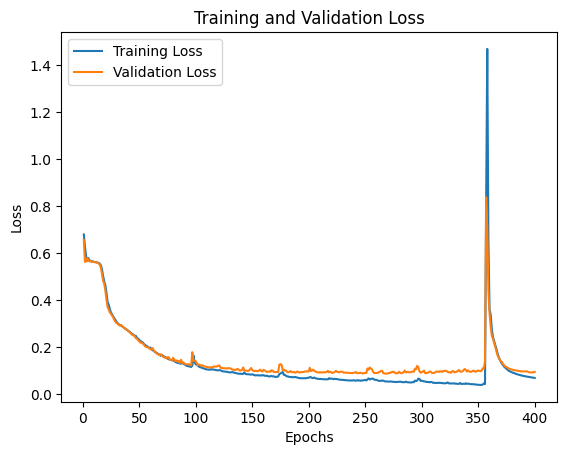

In [4]:
import matplotlib.pyplot as plt

plt.plot(df.epoch, df.loss, label='Training Loss')
plt.plot(df.epoch, df.val_loss, label='Validation Loss')
 
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

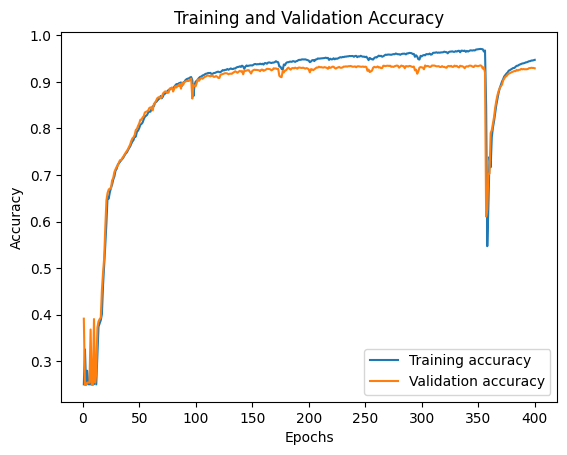

In [5]:
plt.plot(df.epoch, df.accuracy, label='Training accuracy')
plt.plot(df.epoch, df.val_accuracy, label='Validation accuracy')
 
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [12]:
out_dir = './models/clinical_no_TL_1 (0)'

preds = []
labels = []

model = torch.load(f'{out_dir}/best.pt')
model.to('cpu')
model.eval() 
for x,y in iter(test_dataloader): 
    pred = model(x) 
    preds.append(pred.detach())

    labels.append(y)


preds = np.concatenate(preds, axis=0)
labels = np.concatenate(labels, axis=0)

preds = np.argmax(preds, axis=1)
labels = np.argmax(labels, axis=1)

In [11]:
from sklearn.metrics import accuracy_score
accuracy_score(labels,y_pred=preds)

0.9375916758342501

In [13]:
from sklearn.metrics import classification_report

report = classification_report(y_true=labels, y_pred=preds)
print(report)

              precision    recall  f1-score   support

           0       0.98      0.94      0.96     10908
           1       0.97      0.95      0.96     10908
           2       0.95      0.92      0.94     10908
           3       0.86      0.94      0.90     10908

    accuracy                           0.94     43632
   macro avg       0.94      0.94      0.94     43632
weighted avg       0.94      0.94      0.94     43632



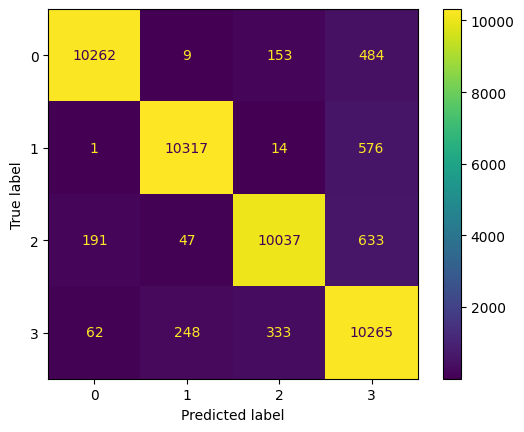

In [14]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


cm = confusion_matrix(y_true=labels,
                      y_pred=preds)


plt.Figure()
disp = ConfusionMatrixDisplay(cm,)

disp.plot(values_format='')
#['lv', 'epi', 'rv', 'base']